<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/notebooks/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Stress From Wearable Devices
- Author: Kevin Spring
- Blog post: https://medium.com/@kevinjspring/stressful-conditions-6e6fc5eb018a

# Summary
We are HealthOn, a wearable device manufacturer focused on improving the health of our users. Our devices measures many physiological data in real time. Using publically available data, we determine the feasability of forecasting stress within a 5-minute period. The best models are only slightly better than guessing the stress or normal state of a user. More data needs to be collected on a variety of subjects under stressful conditions to improve the models.

We recommend:
1. Enhance Feature Measurement: Focus on measuring physiological features that have a high causality with stress, such as respiration rate, heart rate variability, body temperature, and electrodermal activity.

2. Expand Data Collection: Gather a more diverse and comprehensive dataset. Collecting data from a larger sample size of individuals, particularly in both stressful and normal conditions, will allow for a better understanding of the variations and patterns associated with stress.

3. Focus on Stressful Conditions: Prioritize data collection during high-stress situations or events. Collecting data from individuals undergoing stressful experiences, such as work-related stress, performance anxiety, or challenging life events. This targeted data collection will help train the models to better identify and predict stress states accurately.

4. Continuous Model Improvement: It is essential to continuously refine and enhance the machine learning models. Regularly analyze the performance of the models, identify areas for improvement, and iterate on the algorithms and techniques used.

# Table of Contents
* [Introduction](#Introduction)
* [Business Problem](#Business-Problem)
* [Data](#Data)
* [Raw Data Feature Extraction](#Raw-Data-Feature-Extraction)
* [Raw Data EDA and Preprocessing](#Raw-Data-EDA-and-Preprocessing)
* [Preprocessed Data EDA](#Preprocessed-Data-EDA)
* [Feature Engineering](#Feature-Engineering)
* [Model Data Generation](#Modeling-Data-Generation)
* [Modeling](#Modeling)
* [Model Evaluation](#Model-Evaluation)
* [Conclusions](#Conclusions)
* [Recommendations](#Recommendations)
* [References](#References)

# Introduction

HealthOn is focused on improving the health of users through the development of wearable device technology. We currently have a range of smartwatches that collect heart rate, steps taken, and activity level. We are designing our next generation of smartwaches and want to identify which features to include that will take health monitoring to a new level.

## Stress
Stress can have detrimental effects on both mental and physical health. When individuals experience prolonged or chronic stress, it can contribute to various mental health disorders such as anxiety, depression, and burnout. Additionally, stress can become physical symptoms and lead to conditions such as cardiovascular diseases, gastrointestinal problems, weakened immune system, and impaired cognitive functioning. Furthermore, chronic stress can exacerbate existing health conditions and hinder the recovery process. Additionally, stress-related issues contribute to increased healthcare costs, decreased job satisfaction, and lower overall economic growth [1.](#1).

Recognizing the significant economic costs, high prevalence, and negative impacts on individuals, it is crucial to prioritize stress management and promote strategies that reduce stress levels.

# Business Problem

HealthOn is focused on improving the health of users through the development of wearable devices. The goal is to collect and analyze physiological data in real time to provide insights and interventions to improve users health. 

Stress is a significant health related burden for individuals. It can lead to mental and somatic health issues. Physiological hanges in the body are correlated with a person is going into a stressful situation, for example, they will sweat more and their heart rate will increase.

We want to forecast if a user will be in a stressful state in the immediate future. Our device will then notify the user with recommendations to mitigate the stess.

## Project Objective

This project aims to assess the feasability of using physiological data to forecast a subject going into stress. It also aims to identify the most import features in detecting stress for the aim of improving wearable device development and design.

## Stakeholders
- Project Manager
- Business executives

# Data

## Data Source
The [WESAD dataset](https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29) is a publicly available dataset designed for wearable stress and affect detection. It was collected during a lab study and includes physiological and motion data from 15 subjects. The data was recorded using two devices: a chest-worn device called RespiBAN and a wrist-worn device called Empatica E4 ([2.](#2)).

The RespiBAN device provides data on various sensors, including electrocardiogram (ECG), electrodermal activity (EDA), electromyogram (EMG), respiration, body temperature, and three-axis acceleration. All signals from this device are sampled at a rate of 700 Hz.

The Empatica E4 device captures data from sensors such as blood volume pulse (BVP), electrodermal activity (EDA), body temperature, and three-axis acceleration. The sampling rates for these signals are 64 Hz, 4 Hz, 4 Hz, and 32 Hz, respectively.

The dataset contains three affective states: neutral, stress, and amusement, but neutral and ameusment were recaracherized as the same nonstress case (case 0). The neutral state serves as a baseline condition where subjects were engaged in standing or sitting while reading magazines. The amusement condition involves subjects watching a set of eleven funny video clips. The stress condition involves subjects participating in the Trier Social Stress Test (TSST), which includes public speaking and mental arithmetic.

Additionally, the dataset includes self-reports of the subjects obtained using established questionnaires, providing additional information about their experiences and perceptions.

For further details about the dataset structure, data format, study protocol, and self-report questionnaires, you can refer to the dataset's readme-file or the provided source.

## Download instructions
The raw data can be downloaded as a [zip file (2.1 GB)](https://drive.google.com/file/d/1q0WNZGxjuCOfEXhBeZcBbBtno8GI_sYA/view?usp=share_link) or available in a [Google Drive directory](https://drive.google.com/drive/folders/1zP2L7zcTDCgQDjtQbk7VugXGz_o7HGu8?usp=share_link). After downloading the files store them in a top-level Google Drive directory as stress-prediction or modify the code below to reflect your working directory.

In [ ]:
# Import the necessary packages for data loading and processing

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import pickle

# install neurokit2 for signal processing
! pip install neurokit2
import neurokit2 as nk

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# View files in the directory stress-prediction
! ls /content/drive/MyDrive/stress-prediction

data  feature_importance.pdf  img  logs  models


In [ ]:
# set path for data directory
os.chdir('/content/drive/MyDrive/stress-prediction')

# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

## Open and clean up raw data
The data for the WESAD data is stored in seperate folders based on the subject. Within each of these subject subfolders is a pickle (.pkl) file that contains all the phyisological data collected on this subject. This is the file that will be loaded for modeling.

In [ ]:
original_dir = os.path.join(PATH, 'original')
org_WESAD_dir = os.path.join(original_dir, 'WESAD')
print(org_WESAD_dir)

/content/drive/MyDrive/stress-prediction/data/original/WESAD


In [ ]:
class SubjectData:
    
    '''
    This code defines a class called `SubjectData` that stores raw data from 
    the WESAD dataset and provides helper functions to extract wrist or 
    chest data.
    Modified from https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py

    Attributes:
    - `name`: Subject name.
    - `subject_keys`: Keys for subject data.
    - `signal_keys`: Keys for signal data.
    - `chest_keys`: Keys for chest data.
    - `wrist_keys`: Keys for wrist data.

    Methods:
    - `__init__(self, main_path, subject_number)`: Initializes the object with 
       the main path and subject number. Loads the raw data from the WESAD 
       dataset and sets the labels accordingly.
    - `get_wrist_data(self)`: Retrieves the wrist data from the loaded data, 
       adds additional features, and includes the labels. Returns the updated data.
    - `get_chest_data(self)`: Retrieves the chest data from the loaded data 
       and returns it.
    '''
    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']
        # Set labels > or < 2 as non-stress (case 0)
        self.labels[self.labels < 2] = 0
        self.labels[self.labels > 2] = 0
        # Set labels == 2 as stress state (case 1)
        self.labels[self.labels == 2] = 1

    def get_data(self):
        data = self.data['signal']['chest']
        # Modified to extract chest ECG data too
        data.update({'ECG': self.data['signal']['chest']['ECG']})
        data.update({'EMG': self.data['signal']['chest']['EMG']})
        data.update({'HRV': self.data['signal']['wrist']['BVP']})
        data['labels'] = self.labels
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

In [ ]:
def subject_data_import(directory):
  '''
  WESAD raw data is stored in a pkl file of each specific subject.
  This function scans through the directories and imports the pkl files.
  It then calls the SubjectData object and stores the subject dictionaries.
  '''
  import regex as re

  regex = re.compile(r'\d+')
  subject_li = []
  ext = '.pkl' # pickle extension
  # Walk through data directory and only return with specific extension
  for path, dirc, files in os.walk(directory):
    for name in files:
      if name.endswith(ext):
        # Extract the subject number
        subject_number = regex.findall(name) 

        # Create SubjectData object
        subject_li.append(SubjectData(directory, int(subject_number[0]))) 
        
  return subject_li

In [ ]:
# Store all subject data into a list of SubjectData objects
# Each SubjectData object represents a single subject
wesad_sd_li = subject_data_import(org_WESAD_dir)

# Raw Data Feature Extraction

NeuroKit2 is a Python library designed for the analysis and processing of physiological data, specifically focusing on electrocardiography (ECG), electrodermal activity (EDA), electromyography (EMG), and other biosignals. It provides a wide range of functionalities to clean, process, and analyze physiological data efficiently.

The main purpose of NeuroKit2 is to simplify the analysis pipeline for researchers and practitioners working with physiological data. It offers a high-level interface that abstracts complex operations and algorithms, allowing users to focus on their research questions rather than the technical details of signal processing.

One of the key features of NeuroKit2 is its ability to perform comprehensive cleaning and preprocessing of physiological data. It includes functionalities for handling artifacts and noise, detecting and correcting anomalies, filtering signals, and normalizing data. These preprocessing steps are crucial to ensure the quality and reliability of the physiological data before further analysis.

In [ ]:
# Extract data and store in a list
# Will create a list of dictionaries for each subject
wesad_data_li = [ f.get_data() for f in wesad_sd_li ]

In [ ]:
# Inspect features for the first subject
wesad_data_li[0].keys()

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'HRV', 'labels'])

In [ ]:
# Perform automated processing of bio signals using NeuroKit2
# bio_process() is a wrapper function for processing ECG, RSP, EDA, EMG, and other bio signals
# It automatically processes the provided bio signals and extracts relevant features

# Call the bio_process() function with the respective bio signals and sampling rate
processed_data, info = nk.bio_process(eda=wesad_data_li[0]['EDA'].reshape(-1),
                                      rsp=wesad_data_li[0]['Resp'].reshape(-1),
                                      ecg=wesad_data_li[0]['ECG'].reshape(-1),
                                      sampling_rate=700)

# The processed_data variable contains the processed bio features such as 
# cleaned signals, heart rate, R peaks, etc.
# The info variable contains a dictionary with additional information about 
# the processed signals
# Both variables can be used for further analysis or visualization

In [ ]:
# Add temperature to the processed_data dataframe
# This is added after because temperature is not processed with the other
# physiological signals
processed_data['TEMP'] = wesad_data_li[0]['Temp']

## Raw Data EDA and Preprocessing

In [ ]:
# Data size
print(len(wesad_data_li[0]['EDA']))

# Drop rows that all data is Nan
processed_data.dropna(how='all', inplace=True)
len(processed_data)

3847200


3847200

In [ ]:
# Inspect processed data dataframe for first subject
processed_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 44 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   ECG_Raw                           3847200 non-null  float64
 1   ECG_Clean                         3847200 non-null  float64
 2   ECG_Rate                          3847200 non-null  float64
 3   ECG_Quality                       3847200 non-null  float64
 4   ECG_R_Peaks                       3847200 non-null  int64  
 5   ECG_P_Peaks                       3847200 non-null  int64  
 6   ECG_P_Onsets                      3847200 non-null  int64  
 7   ECG_P_Offsets                     3847200 non-null  int64  
 8   ECG_Q_Peaks                       3847200 non-null  int64  
 9   ECG_R_Onsets                      3847200 non-null  int64  
 10  ECG_R_Offsets                     3847200 non-null  int64  
 11  ECG_S_Peaks                       384

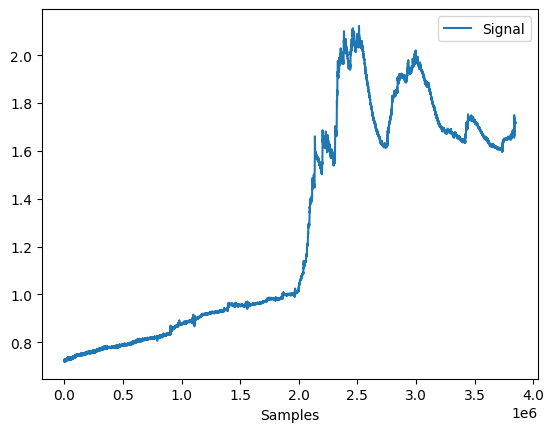

In [ ]:
# inspect the cleaned EDA signal
nk.signal_plot(processed_data['EDA_Clean'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/eda_clean.pdf')

In [ ]:
# What are the unique label IDs?
np.unique(wesad_data_li[0]['labels'])

array([0, 1], dtype=int32)

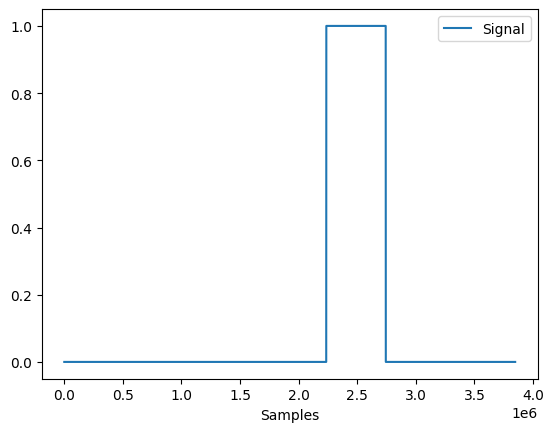

In [ ]:
# Plot the signal
nk.signal_plot(wesad_data_li[0]['labels'])

array([[<Axes: title={'center': '0'}>]], dtype=object)

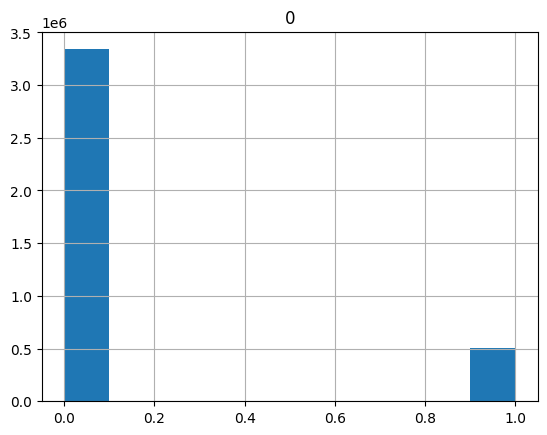

In [ ]:
# Class labels are imbalanced
pd.DataFrame(wesad_data_li[0]['labels']).hist()

In [ ]:
# Find events using the events_find() function from NeuroKit2
# Only on the first subject in exploration

'''
The event_channel parameter represents the channel containing the events
In this case, it is extracted from the 'labels' column of the `wesad_data_li` dataset
The function automatically detects and selects events based on specified parameters
These parameters include threshold, duration, onset time, etc., which can be adjusted as needed
The function returns a dictionary containing arrays of event onsets, durations, labels, and conditions (if specified)
The 'onset' array represents the onset times of the events
The 'duration' array represents the durations of the events
The 'label' array contains the event identifiers
The 'conditions' array contains optional information about the event conditions
The resulting 'events' dictionary can be used for further analysis or visualization
'''
# Call the events_find() function with the event channel from the `wesad_data_li` dataset
events = nk.events_find(event_channel=wesad_data_li[0]['labels'])
events

{'onset': array([2234999]),
 'duration': array([507500]),
 'label': array(['1'], dtype='<U21')}

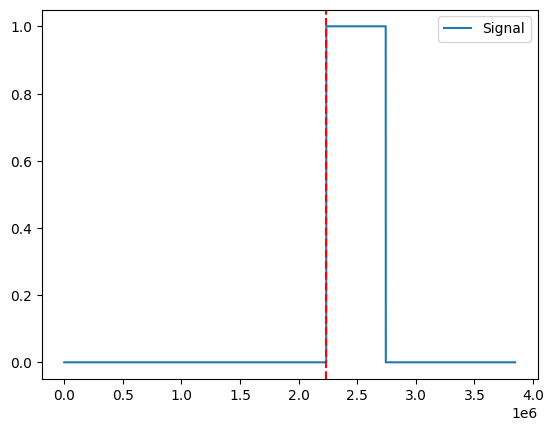

In [ ]:
# Plot the event when stress is induced for the first subject
plot = nk.events_plot(events, wesad_data_li[0]['labels'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/signal_ex.pdf')

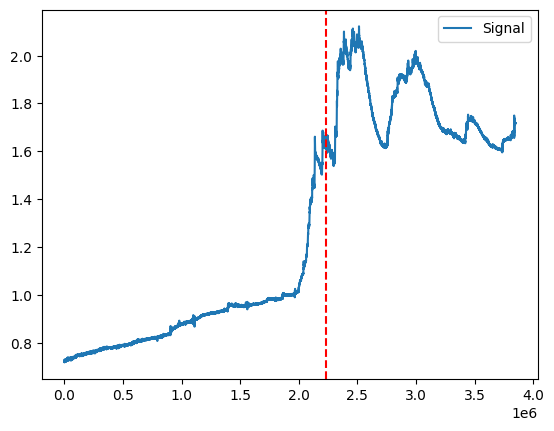

In [ ]:
# Plot the signal event with the cleaned EDA signal
plot = nk.events_plot(events, processed_data['EDA_Clean'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/eda_w_signal.pdf')

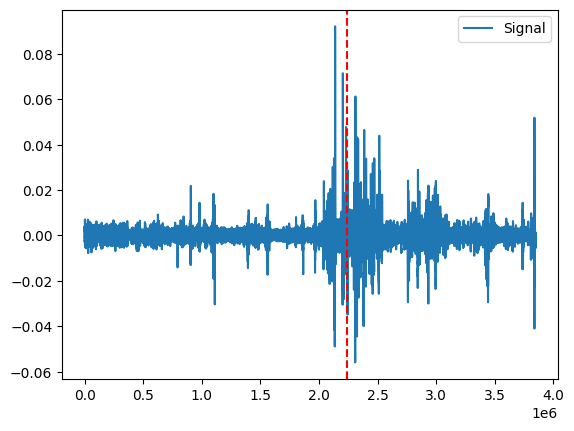

In [ ]:
# Plot the signal event with the EDA Phase signal of the first subject
plot = nk.events_plot(events, processed_data['EDA_Phasic'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/eda_phase_signal.pdf')

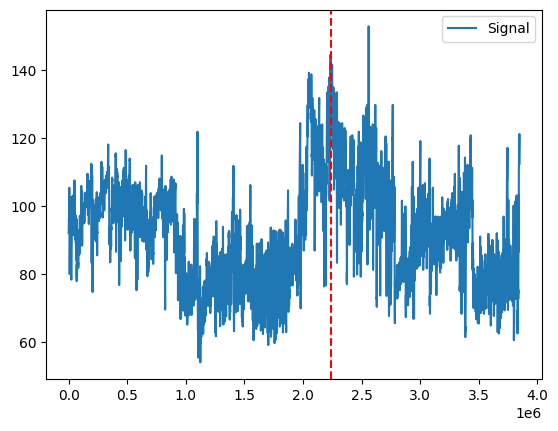

In [ ]:
# Plot the signal event with the ECG rate signal of the first subject
nk.events_plot(events, processed_data['ECG_Rate'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/ECG_Rate_signal.pdf')

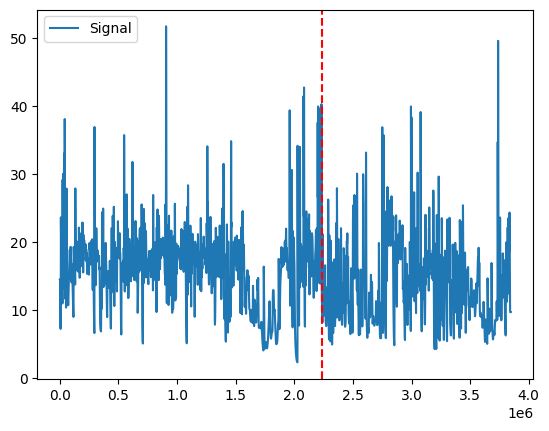

In [ ]:
# Plot the signal event with the respiration rate of the first subject
nk.events_plot(events, processed_data['RSP_Rate'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/RSP_Rate_signal.pdf')

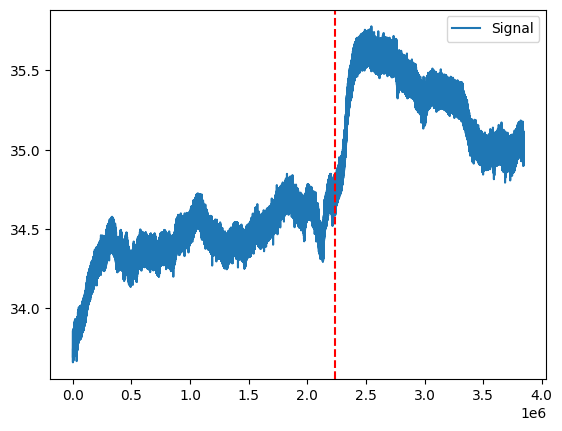

In [ ]:
# Plot the signal event with the body temperature of the first subject
nk.events_plot(events, processed_data['TEMP'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/TEMP_signal.pdf')

In [ ]:
# View all lbels in the processed_data
processed_data.keys()

Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular', 'RSP_Raw', 'RSP_Clean',
       'RSP_Amplitude', 'RSP_Rate', 'RSP_RVT', 'RSP_Phase',
       'RSP_Phase_Completion', 'RSP_Symmetry_PeakTrough',
       'RSP_Symmetry_RiseDecay', 'RSP_Peaks', 'RSP_Troughs', 'EDA_Raw',
       'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'SCR_Onsets', 'SCR_Peaks',
       'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery',
       'SCR_RecoveryTime', 'RSA_P2T', 'RSA_Gates', 'TEMP'],
      dtype='object')

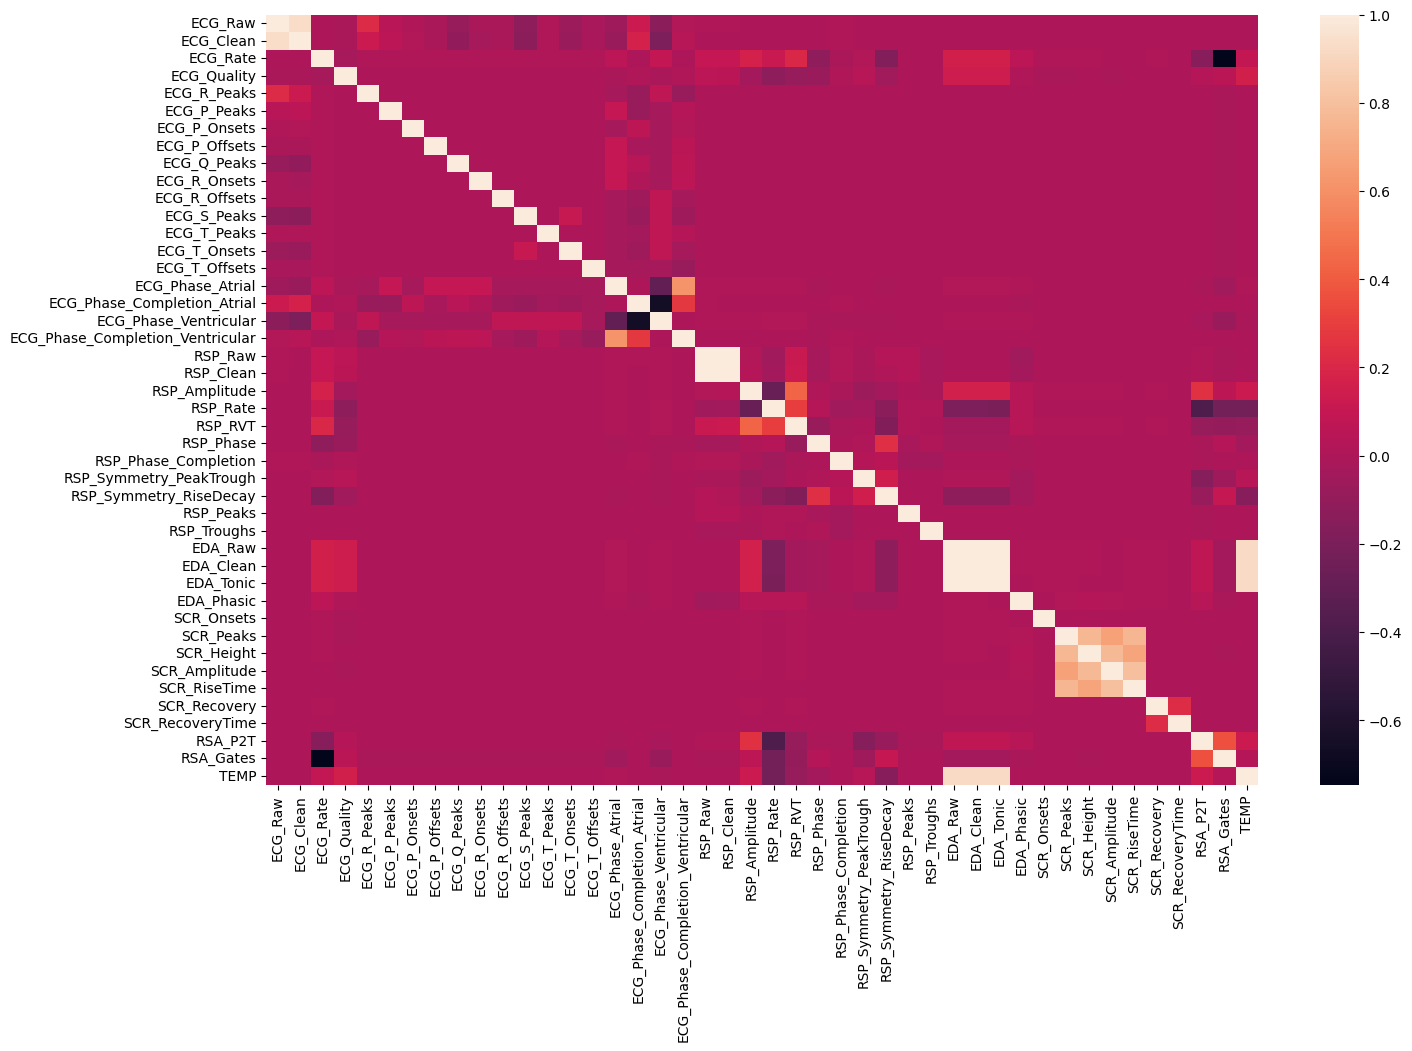

In [ ]:
# Correlation Matrix of all features in the processed_data dataset
import matplotlib.pyplot as plt
import seaborn as sns

corr = processed_data.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr);

In [ ]:
# From the correlation matrix the following features look differentiable 
# and not highly correlated with each other

# RSP_Rate: Respiration rate 
# EDA_Phasic: The rapid/sudden changes in the EDA response
# ECG_Rate: Heart rate
# TEMP: body temperature

processed_data_subset = processed_data[['RSP_Rate', 
                                        'EDA_Phasic', 
                                        'ECG_Rate', 
                                        'TEMP']]
processed_data_subset


,RSP_Rate,EDA_Phasic,ECG_Rate,TEMP
0,14.481092,-0.002589,91.999226,33.695862
1,14.481092,-0.002616,91.999226,33.741333
2,14.481092,-0.002641,91.999226,33.717072
3,14.481092,-0.002665,91.999226,33.741333
4,14.481092,-0.002688,91.999226,33.747406
...,...,...,...,...
3847195,9.690817,-0.000035,112.299465,35.015808
3847196,9.690817,-0.000032,112.299465,35.018921
3847197,9.690817,-0.000029,112.299465,35.020447
3847198,9.690817,-0.000027,112.299465,34.932495


In [ ]:
def modeling_data_process(subject_data):
    """
    Process and prepare the modeling data for further analysis.

    Parameters:
    subject_data (dict): Dictionary containing subject's physiological data.

    Returns:
    processed_data_subset (DataFrame): Processed and subsetted modeling data.
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    # Perform bio-processing on the physiological signals (EDA, RSP, ECG) using NeuroKit2
    processed_data, info = nk.bio_process(eda=subject_data['EDA'].reshape(-1),
                                          rsp=subject_data['Resp'].reshape(-1),
                                          ecg=subject_data['ECG'].reshape(-1),
                                          sampling_rate=700)

    # Add the 'Temp' signal to the processed data
    processed_data['Temp'] = pd.DataFrame.from_dict(subject_data['Temp'])

    # Subset the processed data to select specific features of interest
    processed_data_subset = processed_data[['RSP_Rate', 'EDA_Phasic', 'ECG_Rate', 'Temp']]

    # Add the labels to the processed data
    processed_data_subset['label'] = pd.DataFrame.from_dict(subject_data['labels'])

    # Return the processed and subsetted data
    return processed_data_subset

In [ ]:
# Create a list of processed subject data
model_data = [ modeling_data_process(subject) for subject in wesad_data_li ]

In [ ]:
# Inspect first subject of preprocessed data
model_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [ ]:
# Save the preprocessed data for modeling notebook use

import os
import joblib

# Define the directory path
directory = "data/pickle"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Pickle and save preprocessed data
joblib.dump(model_data, os.path.join(directory, "WESAD_model_data.pickle"))

['data/pickle/WESAD_model_data.pickle']

## Preprocessed Data EDA

The data being used in this section is the preprocessed data where specific features from the physiological data has been extracted. Further statistical features will be extracted to produce the final dataset for model fitting.

After loading the data, this notebook will prepare the data for modeling by splitting it into training, validation, and testing sets, and then normalize the data to ensure that our model is able to learn from it effectively. We'll also use a class weight to give the minority class a weight boost to address class imbalance.

Finally, we'll train and evaluate our model on the testing set and compute various metrics such as accuracy, precision, recall, and F1-score to measure its performance.

In [ ]:
# Import required libraries
import os
import pickle
import joblib

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change working directory to the main file directory on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')

# Define the path of the data directory on Google Drive
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data')

# Load the pickled data using joblib
data = joblib.load(f"{PATH}/pickle/WESAD_model_data.pickle")

Mounted at /content/drive


# Exploratory Data Analysis
Now that we have loaded our pickled data, let's take a look at its structure. The 'data' variable is a list of two elements: a pandas dataframe and a numpy array.We can access the dataframe using `data[0]`. To get information about the the first subject's preprocessed data.



In [ ]:
# Structure of single dataframe in the list
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [ ]:
# Find the size and length of each dataframe
import pandas as pd

# Calculate duration of each dataframe in minutes
for i, df in enumerate(data):
    duration = len(df) / (700 * 60)
    df['duration'] = duration
    
# Create a table showing the duration of each dataframe
df_lengths = pd.DataFrame({'Subject': [f"{i}" for i in range(len(data))],
                           'Observations': [len(df) for df in data],
                           '(min)': [round(df['duration'][0]) for df in data]})
#print(df_lengths.to_string(index=False))
df_lengths.head(15)

,Subject,Observations,(min)
0,0,3847200,92
1,1,3883600,92
2,2,3875900,92
3,3,3663100,87
4,4,3941700,94
5,5,3676400,88
6,6,4144000,99
7,7,4255300,101
8,8,4545100,108
9,9,4496100,107


# Statistical Feature Engineering
We will compute statistical features that capture the patterns in the data that are relevant to predicting stress. Specifically, we will compute the mean and standard deviation of EDA over different time intervals using a rolling window function.

To compute these features, we define a function called `compute_features`. This function takes as input a dataframe and a list of columns to exclude from feature computation. It computes rolling mean and standard deviation features for all columns except those in the exclude_cols list. We define two window sizes, 60 seconds and 300 seconds, which correspond to intervals of one and five minutes, respectively.

We apply the `compute_features` function to each dataframe in the list using a list comprehension, creating a new list of dataframes with the computed features. Finally, we drop any rows with missing values in the resulting dataframes to prepare them for modeling.

In [ ]:
# Define a function to compute mean, standard deviation of past 1 and 5 min
def compute_features(df, Hz_sampled, exclude_cols=[]):
    # Create a copy of the input DataFrame
    df = df.copy()

    # Compute rolling mean and standard deviation features for all columns
    # except those in exclude_cols
    windows = [int(60 * Hz_sampled), int(300 * Hz_sampled)]

    for col in df.columns:
        if col not in exclude_cols:
            for window in windows:
                df[f'{col}_mean_{window // Hz_sampled}s'] = df[col].rolling(window=window).mean()
                df[f'{col}_std_{window // Hz_sampled}s'] = df[col].rolling(window=window).std()

    # Drop rows with missing values
    df.dropna(inplace=True)
    return df

# Apply the function to each dataframe in the list
data_frames_list = [compute_features(df, 700, ['label', 'duration']) for df in data]


In [ ]:
def trim_and_chop(df, Hz_sampled, duration):
    """
    Trim the length of each subject dataframe to be divisible by 
    the desired sequence length, and remove any excess rows.
    
    Args:
    df (DataFrame): The subject's raw dataframe
    Hz_sampled (int): The frequency of the data
    duration (int): The desired duration of each sequence in seconds

    Returns:
    df_trimmed (DataFrame): The trimmed dataframe
    """
    # Calculate the desired length of each sequence
    target_length = Hz_sampled * duration
    
    # Check if the length of the dataframe is already divisible by the target length
    remainder = len(df) % target_length

    if remainder != 0:
        # Calculate the number of rows to trim from the top and bottom
        top_trim = remainder // 2
        bottom_trim = remainder - top_trim

        # Trim the dataframe
        df_trimmed = df.iloc[top_trim: -bottom_trim]
        return df_trimmed
    else:
        return df

# Apply function to each dataframe in the list
trimmed_df_list = [trim_and_chop(df, 700, (5*60)) for df in data_frames_list]

In [ ]:
# Display all the new features
trimmed_df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3570000 entries, 243599 to 3813598
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   RSP_Rate              float64
 1   EDA_Phasic            float64
 2   ECG_Rate              float64
 3   Temp                  float32
 4   label                 int32  
 5   duration              float64
 6   RSP_Rate_mean_60s     float64
 7   RSP_Rate_std_60s      float64
 8   RSP_Rate_mean_300s    float64
 9   RSP_Rate_std_300s     float64
 10  EDA_Phasic_mean_60s   float64
 11  EDA_Phasic_std_60s    float64
 12  EDA_Phasic_mean_300s  float64
 13  EDA_Phasic_std_300s   float64
 14  ECG_Rate_mean_60s     float64
 15  ECG_Rate_std_60s      float64
 16  ECG_Rate_mean_300s    float64
 17  ECG_Rate_std_300s     float64
 18  Temp_mean_60s         float64
 19  Temp_std_60s          float64
 20  Temp_mean_300s        float64
 21  Temp_std_300s         float64
dtypes: float32(1), float64(20), int32(1)


In [ ]:
trimmed_df_list[0].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
RSP_Rate,3570000.0,1.461197e+01,5.467430e+00,2.319673,10.168142,1.500523e+01,18.249221,51.660517
EDA_Phasic,3570000.0,1.652568e-06,5.241135e-03,-0.055904,-0.001296,-6.506016e-05,0.001155,0.092057
ECG_Rate,3570000.0,9.173783e+01,1.577418e+01,53.915276,79.151481,9.108286e+01,102.182506,152.727273
Temp,3570000.0,3.482161e+01,4.541593e-01,34.136749,34.414764,3.464474e+01,35.306641,35.778046
label,3570000.0,1.421569e-01,3.492110e-01,0.000000,0.000000,0.000000e+00,0.000000,1.000000
duration,3570000.0,9.160000e+01,7.389645e-13,91.600000,91.600000,9.160000e+01,91.600000,91.600000
RSP_Rate_mean_60s,3570000.0,1.463973e+01,3.476750e+00,5.527036,12.206068,1.526531e+01,17.405408,22.693054
RSP_Rate_std_60s,3570000.0,3.843627e+00,1.723224e+00,0.875032,2.514544,3.613787e+00,4.842836,9.056521
RSP_Rate_mean_300s,3570000.0,1.478697e+01,2.597034e+00,7.838479,13.046097,1.558837e+01,17.080891,18.760963
RSP_Rate_std_300s,3570000.0,4.612333e+00,1.121828e+00,2.299659,3.677238,4.585956e+00,5.536561,7.192086


In [ ]:
## Include Subject for each dataframe to prepare for concatenation
import warnings
warnings.filterwarnings("ignore")
for i, df in enumerate(trimmed_df_list):
    # Set subject as categorical
    df['subject'] = i
    df['subject'] = df['subject'].astype('category')

# Modeling Data Generation

## Train-Test Split
We are splitting our dataset into training, validation, and testing sets. We are concatenating all of the dataframes together, down-sampling the data to a target frequency of 1Hz, and dropping any columns that have any missing values.

Then, we are splitting the data into training, validation, and testing sets by subject. This is important to ensure that we have a balanced distribution of subjects in each dataset. We are using a 60:20:20 split, where 60% of the subjects are in the training set, 20% are in the validation set, and 20% are in the testing set.

We are standardizing the data using a StandardScaler object, which scales the data to have a mean of 0 and a standard deviation of 1. This is important to ensure that all of the features are on the same scale and that no one feature dominates the others.

Finally, we are converting the subject column to a categorical variable, which is required for training the model with the fit method.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Concatenate the dataframes together
df = pd.concat(trimmed_df_list)

# Downsample the dataframe
sample_hz = 700
target_hz = 1
resample_factor = int(sample_hz / target_hz)
df = df.iloc[::resample_factor, :]

# Drop any columns that have any missing values
df = df.dropna(axis=1, how='any')

# Split the data into training, testing, and validation sets by subject
train_dfs = []
test_dfs = []
val_dfs = []

# Define the percentage split for training, validation, and testing data
train_pct = 0.6
val_pct = 0.2
test_pct = 0.2

# Get a list of unique subject IDs
subject_ids = np.unique(df['subject'])

# Randomly shuffle the subject IDs
np.random.seed(42)
np.random.shuffle(subject_ids)

# Calculate the number of subjects for each dataset
num_train = int(len(subject_ids) * train_pct)
num_val = int(len(subject_ids) * val_pct)
num_test = int(len(subject_ids)) - num_train - num_val

# Split the subject IDs into training, validation, and testing sets
train_subjects = subject_ids[:num_train]
val_subjects = subject_ids[num_train:num_train+num_val]
test_subjects = subject_ids[num_train+num_val:]

# Split the data into training, validation, and testing sets by subject ID
train_df = df[df['subject'].isin(train_subjects)]
val_df = df[df['subject'].isin(val_subjects)]
test_df = df[df['subject'].isin(test_subjects)]

# Standardize the data
scaler = StandardScaler()
cols_to_transform = [col for col in train_df.columns if col not in ['subject', 'label']]
train_df[cols_to_transform] = scaler.fit_transform(train_df[cols_to_transform])
test_df[cols_to_transform] = scaler.transform(test_df[cols_to_transform])
val_df[cols_to_transform] = scaler.transform(val_df[cols_to_transform])

# Set subject as categorical
train_df['subject'] = train_df['subject'].astype('category')
test_df['subject'] = test_df['subject'].astype('category')
val_df['subject'] = val_df['subject'].astype('category')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48600 entries, 243599 to 3612349
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   RSP_Rate              48600 non-null  float64 
 1   EDA_Phasic            48600 non-null  float64 
 2   ECG_Rate              48600 non-null  float64 
 3   Temp                  48600 non-null  float64 
 4   label                 48600 non-null  int32   
 5   duration              48600 non-null  float64 
 6   RSP_Rate_mean_60s     48600 non-null  float64 
 7   RSP_Rate_std_60s      48600 non-null  float64 
 8   RSP_Rate_mean_300s    48600 non-null  float64 
 9   RSP_Rate_std_300s     48600 non-null  float64 
 10  EDA_Phasic_mean_60s   48600 non-null  float64 
 11  EDA_Phasic_std_60s    48600 non-null  float64 
 12  EDA_Phasic_mean_300s  48600 non-null  float64 
 13  EDA_Phasic_std_300s   48600 non-null  float64 
 14  ECG_Rate_mean_60s     48600 non-null  float64 


In [ ]:
# Display which subjects are in which dataset group
print(train_df['subject'].unique())
print(val_df['subject'].unique())
print(test_df['subject'].unique())

[0, 1, 2, 5, 8, 9, 11, 13, 14]
Categories (9, int64): [0, 1, 2, 5, ..., 9, 11, 13, 14]
[4, 7, 10]
Categories (3, int64): [4, 7, 10]
[3, 6, 12]
Categories (3, int64): [3, 6, 12]


In [ ]:
# Total length of each dataset. Since validation and test datasets
# have less subjects, they will have less observations
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(48600, 23)
(16500, 23)
(15000, 23)


## Label Class Imbalance
Class imbalance is a problem in machine learning where the distribution of classes in the training data is not balanced. In some cases, one class may have significantly fewer samples than the other. This can lead to a model that is biased towards the majority class and performs poorly on the minority class.

To address this issue, we can use class weight correction. Class weight correction assigns a weight to each class based on its frequency in the training data. The weight is higher for the minority class and lower for the majority class. This way, the model is encouraged to pay more attention to the minority class during training.

In this code section, we first check the balance of the two label cases (0 is neutral and 1 is stress) in our training data. We find that there is a class imbalance as the number of stress samples is significantly smaller than the number of non-stress samples.

We calculate the class weights by passing the training labels to the `compute_sample_weight` function and setting the `class_weight` parameter to `'balanced'`. This computes the weight for each class based on the inverse of its frequency in the training data.

Next, we define a dictionary that maps each class label to its corresponding weight. We set the weight for the minority (stress) class to be higher than the majority (non-stress) class.

Finally, we plot a bar graph to visualize the class imbalance in our training data. We can see that the stress class has significantly fewer samples than the non-stress class.

In [ ]:
# Balance of the two label cases. 0 is neutral and 1 is stress
# Indicates class imbalance
train_df['label'].value_counts()

0    42610
1     5990
Name: label, dtype: int64

Class 0 (Non-stress): 87.67%
Class 1 (Stress): 12.33%


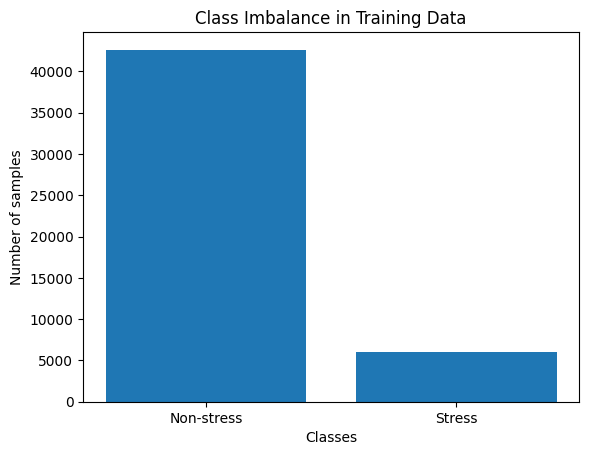

In [ ]:
# Class weight correction
import matplotlib.pyplot as plt
import numpy as np

y_train = train_df['label']

# Calculate class counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_percentages = (class_counts / class_counts.sum()) * 100

# Define class weight dictionary
zero_count = class_counts[0]
one_count = class_counts[1]
class_weights_dict = {0: 1 / zero_count, 1: 1 / one_count}

# Print class percentages
for class_id, percentage in zip(unique_classes, class_percentages):
    print(f"Class {class_id} ({'Non-stress' if class_id == 0 else 'Stress'}): {percentage:.2f}%")

# Create a bar plot for class counts
plt.bar(unique_classes, class_counts, tick_label=['Non-stress', 'Stress'])
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Imbalance in Training Data')
plt.savefig('img/imbalanced_labels.png', dpi=300, bbox_inches='tight')


## Data Generator
The data generated from previous processing steps are structured to be fed into a neural network model. This is done using the `TimeseriesGenerator` class from the `keras` preprocessing module. The data is first divided into batches, with each batch containing a fixed number of sequences of a fixed length. The sequence length is determined based on the desired duration of the time series (in minutes), the sample frequency, and the target sequence length (in rows). For each set, the data is trimmed at the beginning and end to ensure that only full-length sequences are included.

Finally, the `TimeseriesGenerator` class is used to create a generator object for each set of data. The generator object iteratively returns batches of sequence data and corresponding labels, with the start index of each sequence in the batch determined by the generator based on the specified sequence length and stride.

The `TimeseriesGenerator` creates sequences of fixed length from the input data, with each sequence overlapping with the previous one by a certain amount. This overlap is controlled by the stride parameter. Stride refers to the number of rows to move forward between each sequence generated by the `TimeseriesGenerator`.

Here, `stride` is set to 1 minute, which means that each sequence in the generator will be 5 minutes long (the duration parameter), and will start 1 minute after the previous one ended. This means that each sequence in the generator will overlap with the previous one by 4 minutes.

Using a stride like this can help capture more information from the data, since each sequence will contain some data that was also present in the previous sequence.

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define batch size and sequence length
duration = 5 # minutes
batch_size = 10
seq_length = target_hz * 60 * duration # full length of sequence

# Calculate the offset in rows
offset_minutes = 5
offset_rows = offset_minutes * target_hz * 60 # seconds

# Stride
stride = 1 * target_hz * 60 # 1 minute strides

# Extract values from DataFrame
train_data = train_df.drop(['label', 'subject', 'duration'], axis=1).values
val_data = val_df.drop(['label', 'subject', 'duration'], axis=1).values
test_data = test_df.drop(['label', 'subject', 'duration'], axis=1).values

# Trim front and end of the data
train_data = train_data[:-seq_length]
train_labels = train_df['label'][seq_length:].values
val_data = val_data[:-seq_length]
val_labels = val_df['label'][seq_length:].values
test_data = test_data[:-seq_length]
test_labels = test_df['label'][seq_length:].values

# Create data generators
train_gen = TimeseriesGenerator(train_data, 
                                train_labels,
                                length=seq_length, 
                                batch_size=batch_size, 
                                shuffle=False)

val_gen = TimeseriesGenerator(val_data, 
                              val_labels,
                              length=seq_length, 
                              batch_size=batch_size)

test_gen = TimeseriesGenerator(test_data, 
                               test_labels,
                               length=seq_length, 
                               batch_size=batch_size)

In [ ]:
# Display the shape of train_gen, val_gen, and test_gen
data_shape = train_gen[0][0].shape
print(data_shape)

(10, 300, 20)


### Data Generator Shape
The shape (10, 300, 20) indicates a 3-dimensional tensor with 10 samples, each sample containing a sequence of 300 timesteps and 20 features per timestep. This means that the data is organized as 10 batches of sequences, where each sequence is a segment of 300 timesteps with 20 features per timestep. This format is suitable for input to neural network models that expect sequential data with a fixed number of timesteps and features per timestep.

# Modeling
We will explore different machine learning models, including 6 neural network models, a Random Forest model, and an XGBoost model, to predict stress based on time series data. Time series data can be challenging to model due to its sequential nature and the need to capture temporal dependencies. Therefore, we will focus on using neural networks, which have proven to be effective in modeling time series data. Neural networks are capable of automatically learning relevant features and patterns from the data, which can be used to make accurate predictions.

In [ ]:
# Define helper function to plot the training and validation accuracy and loss
def plot_evaluation(model, file_name=None):
    '''
    Plots the Training and validation accuracy as well as the training and validation loss
    over the number of epochs specified.

    Args:
    model: history object returned from the fit() method of the Keras model
    file_name: filename to save the plot

    Returns:
    None
    '''
    # Import necessary libraries
    import matplotlib.pyplot as plt
    
    # Get training and validation accuracy and loss from the model history
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs_range = range(1, len(loss) + 1)
    
    # Create subplots for accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    
    # Plot training and validation accuracy
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    # Plot training and validation loss
    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    
    # Customize the figure
    fig.patch.set_facecolor('white')
    
    # If a file path is provided, Save the plot
    if save_file:
        # Create directories if they don't exist
        directory = os.path.dirname(file_name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        # Save the plot
        plt.savefig(f'{file_name}')
        # Display plot
        plt.show()

In [ ]:
# Define function to evaluate the model and plot the training and validation metrics
def evaluate_model(model_filepath, history_filepath, val_data, test_data, save_plot_path):
    '''
    Evaluate a Keras model and plot the training and validation metrics.

    Args:
    model_filepath: path to the Keras model file
    history_filepath: path to the pickle file containing the training history of the model
    val_data: validation data generator
    test_data: testing data generator
    save_plot_path: path to save the plot

    Returns:
    The trained Keras model and the training history object
    '''
    # Import necessary libraries
    from tensorflow.keras.models import load_model
    import joblib
    
    # Load the trained Keras model
    model = load_model(model_filepath)
    
    # Evaluate the model on the validation set
    model_eval_val = model.evaluate(val_data, use_multiprocessing=True, batch_size=batch_size)
    
    # Load the training fit history from the pickle file
    fit_history = joblib.load(history_filepath)
    
    # Plot the training and validation metrics
    plot_evaluation(fit_history, save_plot_path)
    
    # Evaluate the model on the test set and print the validation and test accuracy
    model_eval_test = model.evaluate(test_data, use_multiprocessing=True, batch_size=batch_size)
    print(f'Validation Binary Accuracy is: {model_eval_val[1]:.2f}')
    print(f'Testing Binary Accuracy is: {model_eval_test[1]:.2f}')
    
    # Return the trained model and the training history object
    return model, fit_history


In [ ]:
# Callbacks Function
def callbacks(checkpoint_file, patience=3):
  '''
  This function defines a set of callbacks that can be used during the training 
  of a neural network to monitor the performance and behavior of the training 
  process.
  '''

  # import necessary libraries
  from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', 
                             verbose=1, 
                             patience=patience,
                             restore_best_weights=True,
                             mode='min'
                             ),
              ModelCheckpoint(checkpoint_file, 
                              save_best_only=True,
                              verbose=0
                              ),
              TensorBoard(log_dir='./logs', histogram_freq=1, 
                          embeddings_freq=1, 
                          update_freq='epoch')
  ]
  return callbacks

In [ ]:
def confusion_matrix_plot(model, data, save_file=None):

  '''
  Computes and plots the confusion matrix for a given model and data. 
  It first makes predictions using the model on the given data, and then 
  computes the confusion matrix using sklearn.metrics.confusion_matrix. 
  The resulting matrix is then plotted using seaborn.heatmap. If a save_file 
  argument is provided, the plot is saved as an image.
  '''
  import seaborn as sns
  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix

  # Predict the labels for the data using the trained model
  y_pred_probs = model.predict(data)
  y_pred = (y_pred_probs > 0.5).astype(int)

  # Get the true labels for the data
  y_true = []
  for _, batch_labels in data:
      y_true.extend(batch_labels)
  y_true = np.array(y_true)

  # Compute the confusion matrix using sklearn.metrics
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix using seaborn and matplotlib
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')

  # Save the plot to a file if specified
  if save_file:
    # Create directories if they don't exist
      directory = os.path.dirname(save_file)
      if not os.path.exists(directory):
            os.makedirs(directory)
      # Save the plot
      plt.savefig(f'{save_file}')

      # Display the plot
      plt.show()

In [ ]:
# Classification Report Helper Function

def classification_report_output(model, data, save_file=None):
    '''
    This function computes the classification report of a model's performance 
    on a given dataset. It first uses the trained model to predict the labels 
    of the data, and then computes the precision, recall, f1-score, and support 
    for each class using sklearn's classification_report function.
    The output is a Pandas dataframe containing these metrics for each class.
    If a file path is provided, the report is saved as a CSV file.
    Finally, the report is printed to the console.
    '''
    # Import necessary libraries
    from sklearn.metrics import classification_report
    
    # Make predictions on the data using the model
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Extract the true labels from the data generator
    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    # Compute the classification report as a dictionary and convert to a Pandas dataframe
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # If a file path is provided, save the report as a CSV file
    if save_file:
        # Create directories if they don't exist
        directory = os.path.dirname(save_file)
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        report_df.to_csv(save_file, index=True)

    # Print the report to the console
    print(report_df)


## Baseline Model (Model 0)
This baseline neural network model is a simple Densely Connected Network that starts by flattening the time series data and then runs it through two Dense layers. The model has a single output for binary classification. The loss function used is binary_crossentropy and the optimizer used is Adam with a learning rate of 0.001. The model is evaluated using binary accuracy metric. This model is a quick and cheap way to test the data generator and the evaluation metrics.

### Evaluation Metrics
The F1-score balances both precision and recall. Similar to the recall, the F1-score for class 0 remains relatively high across all datasets, indicating a good balance between precision and recall. However, the F1-score for class 1 varies, with the lowest value in the validation dataset.

Overall, the model performs well in identifying non-stress instances but struggles to accurately detect stress instances. Further improvements are necessary to enhance the model's ability to classify stress accurately.





In [ ]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.
'''

no_features = train_gen[0][0].shape[2]

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten

# Build Model 0
inputs = keras.Input(shape=(seq_length, no_features))
x = Flatten()(inputs)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
model_0 = keras.Model(inputs, outputs, name='model_0')

# Compile Model 0
model_0.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['binary_accuracy'])


model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 flatten (Flatten)           (None, 6000)              0         
                                                                 
 dense (Dense)               (None, 16)                96016     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 96,033
Trainable params: 96,033
Non-trainable params: 0
_________________________________________________________________


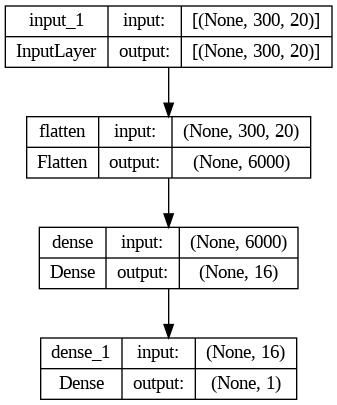

In [ ]:
# Figure showing neural network
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_0, to_file='models/model_0.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_0_filepath = 'models/model_dense.keras'
history_0_filepath = 'models/trainHistoryDict/model_0_dense_history.pkl'

In [ ]:
# Fit the model to the training data
history_0 = model_0.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=True, 
                        epochs=epochs,
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_0_filepath,
                                            patience=5),
                        )

# Pickle the Traning Fit History
with open(history_0_filepath, 'wb') as file_pi:
    pickle.dump(history_0, file_pi)

Epoch 1/200
4800/4800 [==============================] - 23s 4ms/step - loss: 1.6737e-04 - binary_accuracy: 0.7183 - val_loss: 7.0890 - val_binary_accuracy: 0.5348
Epoch 2/200
4800/4800 [==============================] - 18s 4ms/step - loss: 1.2191e-04 - binary_accuracy: 0.7301 - val_loss: 4.8773 - val_binary_accuracy: 0.6754
Epoch 3/200
4800/4800 [==============================] - 17s 4ms/step - loss: 1.0364e-04 - binary_accuracy: 0.8411 - val_loss: 6.3220 - val_binary_accuracy: 0.5842
Epoch 4/200
4800/4800 [==============================] - 17s 4ms/step - loss: 8.5044e-05 - binary_accuracy: 0.8369 - val_loss: 7.1377 - val_binary_accuracy: 0.5312
Epoch 5/200
4800/4800 [==============================] - 17s 4ms/step - loss: 7.9502e-05 - binary_accuracy: 0.8359 - val_loss: 5.5864 - val_binary_accuracy: 0.6325
Epoch 6/200
4800/4800 [==============================] - 18s 4ms/step - loss: 6.7938e-05 - binary_accuracy: 0.8659 - val_loss: 3.7385 - val_binary_accuracy: 0.7544
Epoch 7/200
4800

1590/1590 [==============================] - 5s 3ms/step - loss: 3.7385 - binary_accuracy: 0.7544


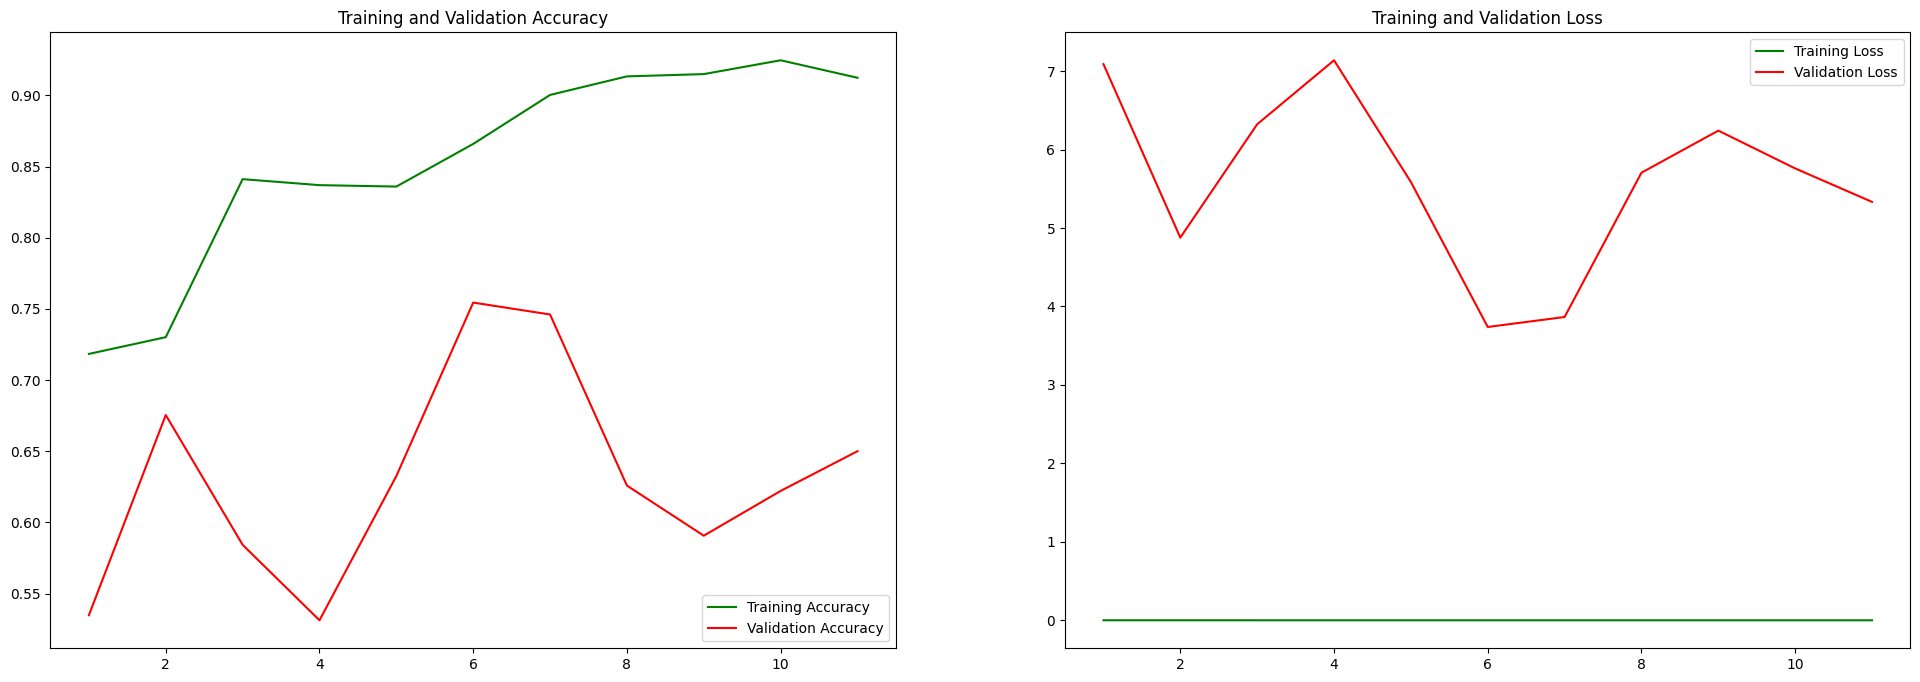

1440/1440 [==============================] - 6s 4ms/step - loss: 4.2598 - binary_accuracy: 0.7203
Validation Binary Accuracy is: 0.75
Testing Binary Accuracy is: 0.72


In [ ]:
# Load and Evaluate Model
model_0, history_0 = evaluate_model(model_0_filepath, 
                         history_0_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_0_evaluation.pdf')

4800/4800 [==============================] - 7s 1ms/step


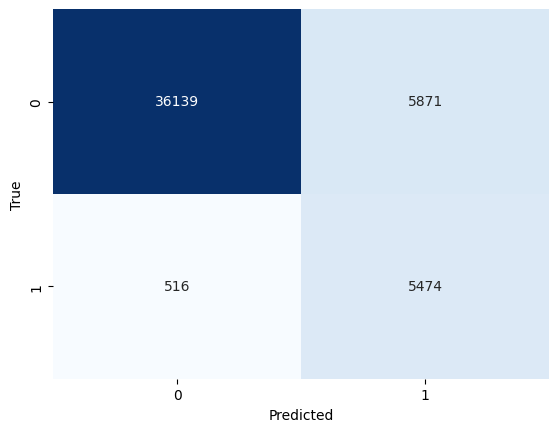

4800/4800 [==============================] - 7s 1ms/step
              precision    recall  f1-score       support
0              0.985923  0.860248  0.918808  42010.000000
1              0.482503  0.913856  0.631555   5990.000000
accuracy       0.866938  0.866938  0.866938      0.866938
macro avg      0.734213  0.887052  0.775181  48000.000000
weighted avg   0.923100  0.866938  0.882961  48000.000000
1590/1590 [==============================] - 2s 1ms/step


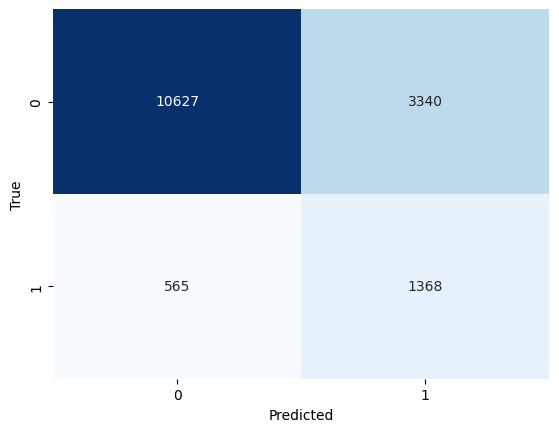

1590/1590 [==============================] - 2s 1ms/step
              precision    recall  f1-score       support
0              0.949518  0.760865  0.844787  13967.000000
1              0.290569  0.707708  0.411986   1933.000000
accuracy       0.754403  0.754403  0.754403      0.754403
macro avg      0.620043  0.734287  0.628387  15900.000000
weighted avg   0.869408  0.754403  0.792171  15900.000000
1440/1440 [==============================] - 2s 1ms/step


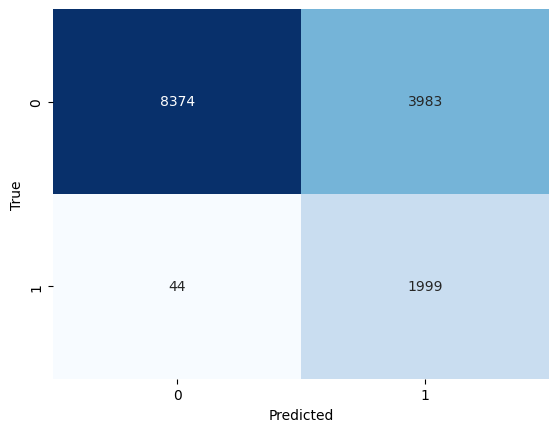

1440/1440 [==============================] - 2s 1ms/step
              precision    recall  f1-score       support
0              0.994773  0.677673  0.806161  12357.000000
1              0.334169  0.978463  0.498193   2043.000000
accuracy       0.720347  0.720347  0.720347      0.720347
macro avg      0.664471  0.828068  0.652177  14400.000000
weighted avg   0.901050  0.720347  0.762468  14400.000000


In [ ]:
confusion_matrix_plot(model_0, train_gen, save_file='models/evaluate/model_0_train_confusion_matrix.pdf')
classification_report_output(model_0, train_gen, save_file=None)
confusion_matrix_plot(model_0, val_gen, save_file='models/evaluate/model_0_val_confusion_matrix.pdf')
classification_report_output(model_0, val_gen, save_file=None)
confusion_matrix_plot(model_0, test_gen, save_file='models/evaluate/model_0_test_confusion_matrix.pdf')
classification_report_output(model_0, test_gen, save_file=None)

In [ ]:
# Hyperparameter Tuning
def nn_lstm_hyperparameter_tuning(build_model_fn, 
                                  lstm_units_list, 
                                  weight_penalty_list,
                                  learning_rates_list, 
                                  callback_filepath):
    '''
    Performs hyperparameter tuning for an LSTM-based neural network model. 
    It takes in a function that constructs the model with given 
    hyperparameters, as well as lists of `lstm_units`, `weight_penalty`, 
    and `learning_rates` to loop through. For each combination of 
    hyperparameters, the function trains the model on the training set and 
    evaluates its performance on the validation set using the F1-score. The 
    function returns the best model, hyperparameters, and history of the 
    training process. The `callbacks` function is also called to save the 
    best model based on the validation loss.
    '''
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Placeholder for the best model and its corresponding hyperparameters
    best_model = None
    best_lstm_units = None
    best_learning_rate = None
    best_penalty = None
    best_val_metric = -np.inf  # Set initial value to negative infinity

    # Loop through all combinations of LSTM units and learning rates
    for lstm_units in lstm_units_list:
        for learning_rate in learning_rates_list:
          for weight_penalty in weight_penalty_list:
            # Display the variables
            print(f'lstm_units: {lstm_units}, learning_rate: {learning_rate}, weight_penalty: {weight_penalty}')
            
            # Build model
            model = build_model_fn(lstm_units, learning_rate)

            # Set weight penalty
            class_weights_dict[1] = class_weights_dict[1] * weight_penalty         

            # Train the model on the training set
            history = model.fit(train_gen, 
                                shuffle=False,
                                validation_data=val_gen, 
                                epochs=epochs, 
                                class_weight=class_weights_dict,
                                callbacks=callbacks(callback_filepath,
                                                    patience=5))

            # Evaluate the model on the validation set
            y_val_true = np.concatenate([y for x, y in val_gen], axis=0)
            y_val_pred_probs = model.predict(val_gen)
            y_val_pred = (y_val_pred_probs > 0.5).astype(int)

            # Calculate the performance metric(s) of interest (e.g., F1-score)
            val_f1_score = f1_score(y_val_true, y_val_pred)

            # Update the best model and hyperparameters if the current model is better
            if val_f1_score > best_val_metric:
                best_history = history
                best_val_metric = val_f1_score
                best_model = model
                best_lstm_units = lstm_units
                best_learning_rate = learning_rate
                best_penalty = weight_penalty

    # Print the best LSTM units and learning rate
    print(f"Best LSTM units: {best_lstm_units}")
    print(f"Best learning rate: {best_learning_rate}")
    print(f"Best weight_penalty: {best_penalty}")

    return history, best_model, best_lstm_units, best_learning_rate, best_penalty


## Model 1

Model 1 includes a Long Short-Term Memory (LSTM) neural network. LSTM models are a type of recurrent neural network that is particularly suited for time series data due to their ability to remember and use past information while processing new data points. LSTMs use special units, called memory cells, that can store information over a long period of time and selectively forget or update that information based on the current input. This allows the model to capture long-term dependencies in the data, which is often important in time series forecasting or classification tasks. LSTMs have been shown to outperform traditional machine learning models on a variety of time series problems.

Compared to Model 0, which is a simple densely connected neural network, the LSTM model is expected to have better performance in modeling time series data because it can capture the sequential dependencies within the data.

### Evaluation Metrics
Model 1 generally has similar precision and recall compared to Model 0 compared to Model 0. Model 1 exhibits similar F1-scores for the stress class in all datasets. Overall, Model 1 demonstrates similar performance in correctly identifying stress instances compared to Model 0.

In [ ]:
# Model 1
def build_lstm_model(lstm_units, learning_rate):
    from tensorflow import keras
    from tensorflow.keras.optimizers import Adam
    from keras.layers import Dense, LSTM

    inputs = keras.Input(shape=(seq_length, no_features))
    x = LSTM(units=lstm_units, 
          activation='tanh', 
          dropout=0.5)(inputs)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    return model

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_1_filepath = 'models/model_1_lstm.keras'
history_1_filepath = 'models/trainHistoryDict/model_1_lstm_history.pkl'

In [ ]:

lstm_units_list = [32]
learning_rates_list = [0.001]
class_weight_penalty= [1]
# Fit the model to the training data

history_1, model_1, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                                      build_lstm_model,
                                                                      lstm_units_list,
                                                                      class_weight_penalty,
                                                                      learning_rates_list,
                                                                      model_1_filepath)

# Pickle the Traning Fit History
with open(history_1_filepath, 'wb') as file_pi:
    pickle.dump(history_1, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm (LSTM)                 (None, 32)                6784      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4800/4800 [==============================] - 56s 11ms/step - loss: 1.5179e-05 - binary_accuracy: 0.8609 - val_loss: 1.0099 - val_binary_accuracy: 0.5262
Epoch 2/200
4800/4800 [==============================] - 52s 11ms/step - loss: 1.1607e-05 - binary_acc

1590/1590 [==============================] - 10s 6ms/step - loss: 1.0099 - binary_accuracy: 0.5262


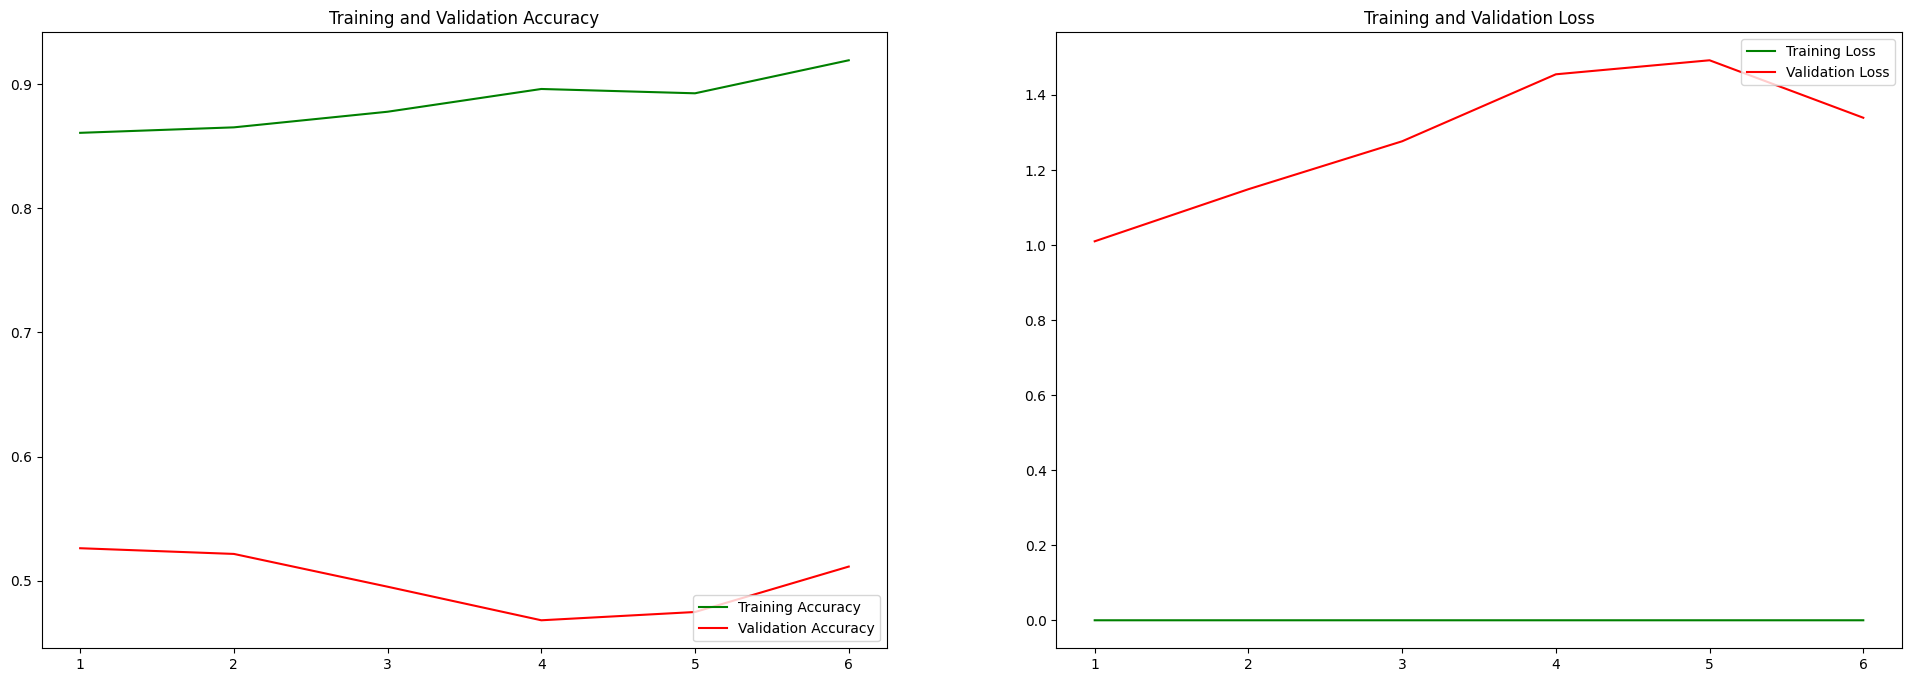

1440/1440 [==============================] - 8s 5ms/step - loss: 0.6930 - binary_accuracy: 0.7222
Validation Binary Accuracy is: 0.53
Testing Binary Accuracy is: 0.72


In [ ]:
# Load and Evaluate Model
model_1, history_1 = evaluate_model(model_1_filepath, 
                         history_1_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_1_evaluation.pdf')

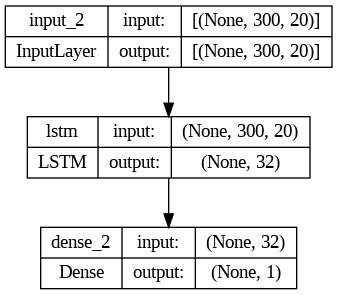

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_1, to_file='models/model_1_arch.png', show_shapes=True, show_layer_names=True)

4800/4800 [==============================] - 21s 4ms/step


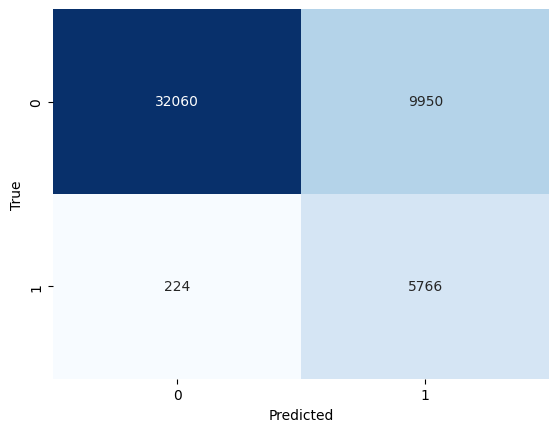

4800/4800 [==============================] - 21s 4ms/step
              precision    recall  f1-score       support
0              0.993062  0.763152  0.863058  42010.000000
1              0.366887  0.962604  0.531282   5990.000000
accuracy       0.788042  0.788042  0.788042      0.788042
macro avg      0.679974  0.862878  0.697170  48000.000000
weighted avg   0.914920  0.788042  0.821655  48000.000000
1590/1590 [==============================] - 7s 4ms/step


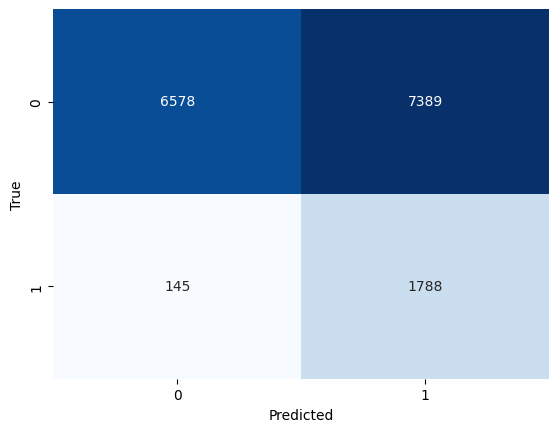

1590/1590 [==============================] - 7s 4ms/step
              precision    recall  f1-score       support
0              0.978432  0.470967  0.635863  13967.000000
1              0.194835  0.924987  0.321872   1933.000000
accuracy       0.526164  0.526164  0.526164      0.526164
macro avg      0.586634  0.697977  0.478867  15900.000000
weighted avg   0.883168  0.526164  0.597690  15900.000000
1440/1440 [==============================] - 6s 4ms/step


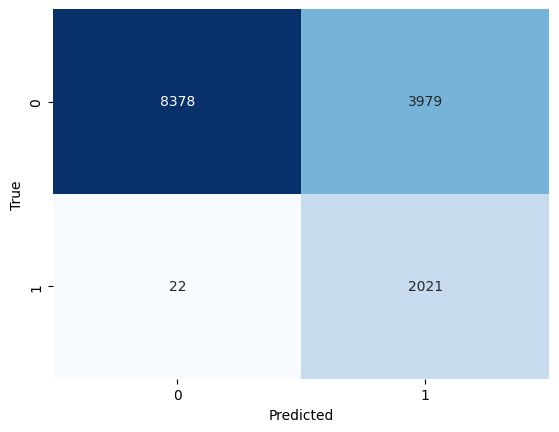

1440/1440 [==============================] - 6s 4ms/step
              precision    recall  f1-score       support
0              0.997381  0.677996  0.807246  12357.000000
1              0.336833  0.989232  0.502549   2043.000000
accuracy       0.722153  0.722153  0.722153      0.722153
macro avg      0.667107  0.833614  0.654897  14400.000000
weighted avg   0.903666  0.722153  0.764017  14400.000000


In [ ]:
confusion_matrix_plot(model_1, train_gen, save_file='models/evaluate/model_1_train_confusion_matrix.pdf')
classification_report_output(model_1, train_gen, save_file=None)
confusion_matrix_plot(model_1, val_gen, save_file='models/evaluate/model_1_val_confusion_matrix.pdf')
classification_report_output(model_1, val_gen, save_file=None)
confusion_matrix_plot(model_1, test_gen, save_file='models/evaluate/model_1_test_confusion_matrix.pdf')
classification_report_output(model_1, test_gen, save_file=None)

## Model 2

This is a deeper LSTM-based neural network architecture compared to model 1. The model consists of two LSTM layers with a dropout of 0.5 and an output layer. The first LSTM layer takes input of shape (300, 20) and returns a sequence of the same shape, which is then fed into the second LSTM layer. The second LSTM layer has half the number of units compared to the first LSTM layer. The output layer has a sigmoid activation function, which makes it suitable for binary classification problems. The dropout layers help to reduce overfitting, and the return_sequences parameter allows the model to process sequences of variable length.

### Evaluation Metrics
Based on the results obtained, model 2 has not shown any significant improvement compared to models 0 and 1. 

Model 2 architecture includes two LSTM layers with a lower number of LSTM units in the second layer compared to the first layer. The addition of the second LSTM layer is meant to provide more complex representations of the input data, which could help capture temporal patterns more effectively. Also, the use of the dropout layers can prevent overfitting and improve generalization.

Overall, Model 2 demonstrates lower performance in correctly identifying stress instances and maintaining similar performance for non-stress instances compared to Models 0 and 1. This suggests that Model 2 may be less effective in stress detection compared to the previous models.

In [ ]:
# Model 2
def build_lstm_2_model(lstm_units, learning_rate):
    import keras
    from keras.layers import LSTM, Dense
    from keras.models import Sequential
    from tensorflow.keras.optimizers import Adam

    # Build the model
    inputs = keras.Input(shape=(seq_length, no_features))

    # LSTM layer
    x = LSTM(lstm_units, 
            activation='tanh', 
            input_shape=(seq_length, no_features),
             return_sequences = True,
            dropout=0.5)(inputs) # Dropout
    # Second LSTM Layer
    x = LSTM(lstm_units//2,
            activation='tanh', 
            dropout=0.5)(x) # Dropout
    outputs = Dense(1, 'sigmoid')(x)
    model = keras.Model(inputs, outputs)

    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    model.summary()

    return model

In [ ]:
model_2_filepath = 'models/model_2_multiLSTM.keras'
history_2_filepath = 'models/trainHistoryDict/model_2_dense_history.pkl'
lstm_units_list = [64]
#learning_rates_list = [best_learning_rate]
#class_weight_penalty= [best_penalty]

In [ ]:
# Fit the model to the training data
history_2, model_2, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_model,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_2_filepath)
# Pickle the Traning Fit History
with open(history_2_filepath, 'wb') as file_pi:
    pickle.dump(history_2, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 300, 64)           21760     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4800/4800 [==============================] - 96s 19ms/step - loss: 1.9660e-05 - binary_accuracy: 0.7830 - val_loss: 0.9

1590/1590 [==============================] - 14s 8ms/step - loss: 0.9258 - binary_accuracy: 0.6458


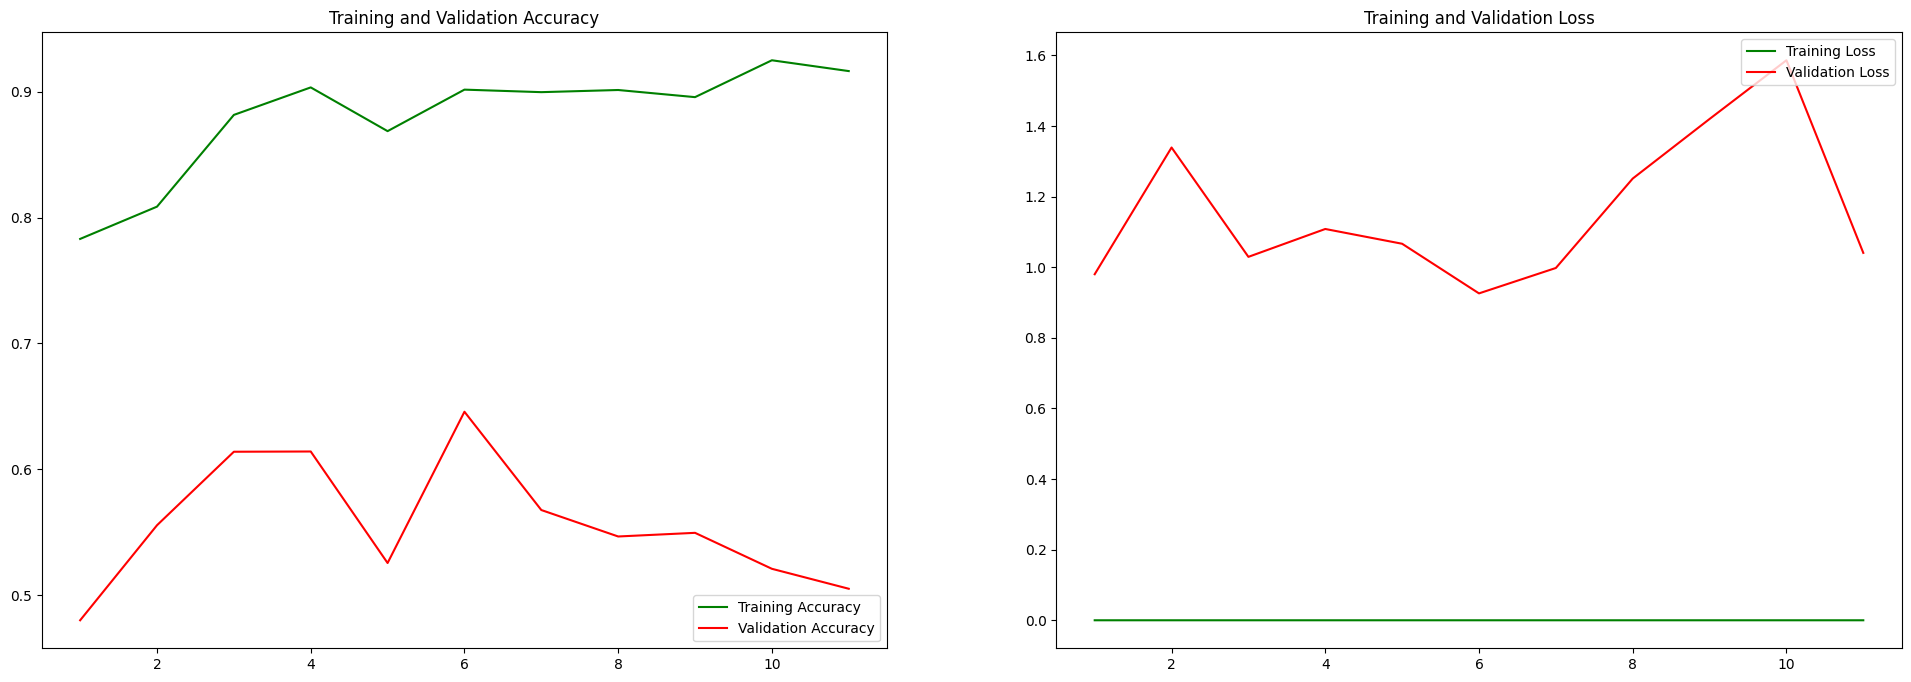

1440/1440 [==============================] - 12s 8ms/step - loss: 0.7254 - binary_accuracy: 0.7335
Validation Binary Accuracy is: 0.65
Testing Binary Accuracy is: 0.73


In [ ]:
# Load and Evaluate Model
model_2, history_2 = evaluate_model(model_2_filepath, 
                         history_2_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_2_evaluation.pdf')

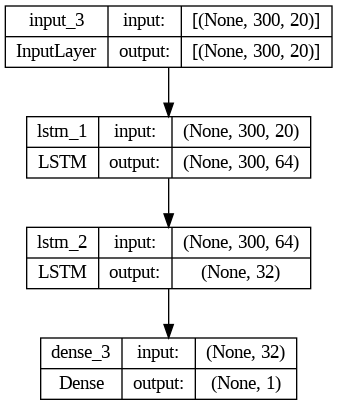

In [ ]:
# Plot model visualization
from keras.utils import plot_model

plot_model(model_2, to_file='models/model_2_arch.png', show_shapes=True, show_layer_names=True)

4800/4800 [==============================] - 36s 7ms/step


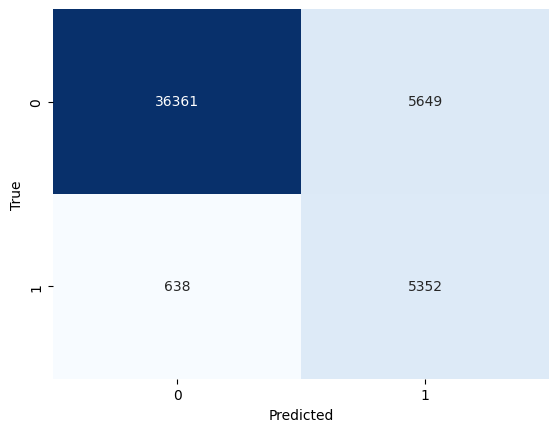

4800/4800 [==============================] - 36s 7ms/step
              precision    recall  f1-score       support
0              0.982756  0.865532  0.920427  42010.000000
1              0.486501  0.893489  0.629981   5990.000000
accuracy       0.869021  0.869021  0.869021      0.869021
macro avg      0.734629  0.879511  0.775204  48000.000000
weighted avg   0.920828  0.869021  0.884182  48000.000000
1590/1590 [==============================] - 12s 8ms/step


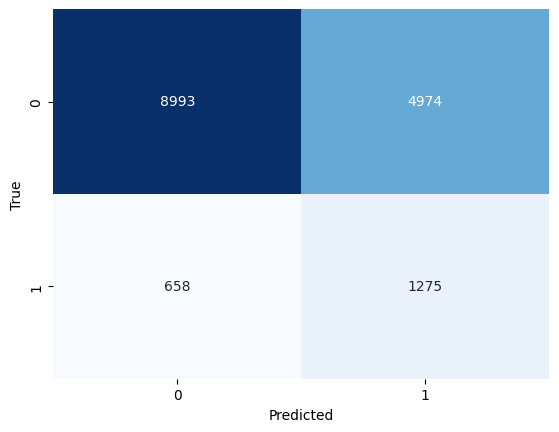

1590/1590 [==============================] - 12s 7ms/step
              precision    recall  f1-score       support
0              0.931821  0.643875  0.761538  13967.000000
1              0.204033  0.659596  0.311660   1933.000000
accuracy       0.645786  0.645786  0.645786      0.645786
macro avg      0.567927  0.651736  0.536599  15900.000000
weighted avg   0.843342  0.645786  0.706845  15900.000000
1440/1440 [==============================] - 11s 7ms/step


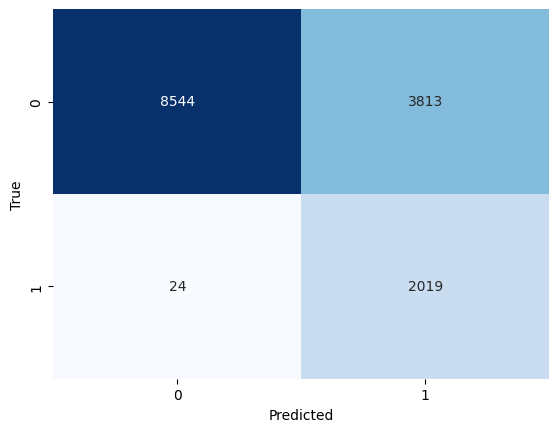

1440/1440 [==============================] - 11s 7ms/step
              precision    recall  f1-score       support
0              0.997199  0.691430  0.816631  12357.000000
1              0.346193  0.988253  0.512762   2043.000000
accuracy       0.733542  0.733542  0.733542      0.733542
macro avg      0.671696  0.839841  0.664696  14400.000000
weighted avg   0.904837  0.733542  0.773519  14400.000000


In [ ]:
confusion_matrix_plot(model_2, train_gen, save_file='models/evaluate/model_2_train_confusion_matrix.pdf')
classification_report_output(model_2, train_gen, save_file=None)
confusion_matrix_plot(model_2, val_gen, save_file='models/evaluate/model_2_val_confusion_matrix.pdf')
classification_report_output(model_2, val_gen, save_file=None)
confusion_matrix_plot(model_2, test_gen, save_file='models/evaluate/model_2_test_confusion_matrix.pdf')
classification_report_output(model_2, test_gen, save_file=None)

## Model 3
The model architecture of Model 3 is similar to Model 2, with the addition of BatchNormalization layers after each LSTM layer. BatchNormalization is a technique that normalizes the inputs of each layer, making the training process more efficient and reducing the risk of overfitting.

Model 3 is expected to perform better, as it includes BatchNormalization layers to further improve the model's training stability and generalization ability.

### Evaluation Metrics
Model 3 has lower precision for non-stress class compared to Models 0, 1, and 2. It also has worse performance according to F1-score of the stress class (class 1). Overall, Model 3 demonstrates lower performance compared tothe previous models in terms of precision and F1-score and would not be effective in classifying for our business problem.



In [ ]:
## Model 3
def build_lstm_2_norm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout
  from tensorflow.keras.optimizers import Adam
  from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

  # Build the model
  inputs = keras.Input(shape=(seq_length, no_features))

  # LSTM layer
  x = LSTM(lstm_units, 
          activation='tanh', 
          input_shape=(seq_length, no_features),
          return_sequences=True,
          dropout=0.5)(inputs) # Dropout
  # Second LSTM Layer
  x = BatchNormalization()(x)
  x = LSTM(lstm_units//2, 
          activation='tanh', 
          return_sequences=False,  # Set return_sequences=False
          dropout=0.5)(x) # Dropout
  x = BatchNormalization()(x)
  # Dense layer for binary prediction
  outputs = Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs, outputs)

  # Compile
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate=learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [ ]:
model_3_filepath = 'models/model_3_multiLSTM.keras'
history_3_filepath = 'models/trainHistoryDict/model_3_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
#class_weight_penalty = [1, 2, 10, 100, 1000]

In [ ]:
# Fit the model and tune hyperparameters
history_3, model_3, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_norm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_3_filepath)
# Pickle the Training Fit History
with open(history_3_filepath, 'wb') as file_pi:
    pickle.dump(history_3, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 300, 64)           21760     
                                                                 
 batch_normalization (BatchN  (None, 300, 64)          256       
 ormalization)                                                   
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 de

1590/1590 [==============================] - 14s 8ms/step - loss: 0.6252 - binary_accuracy: 0.7592


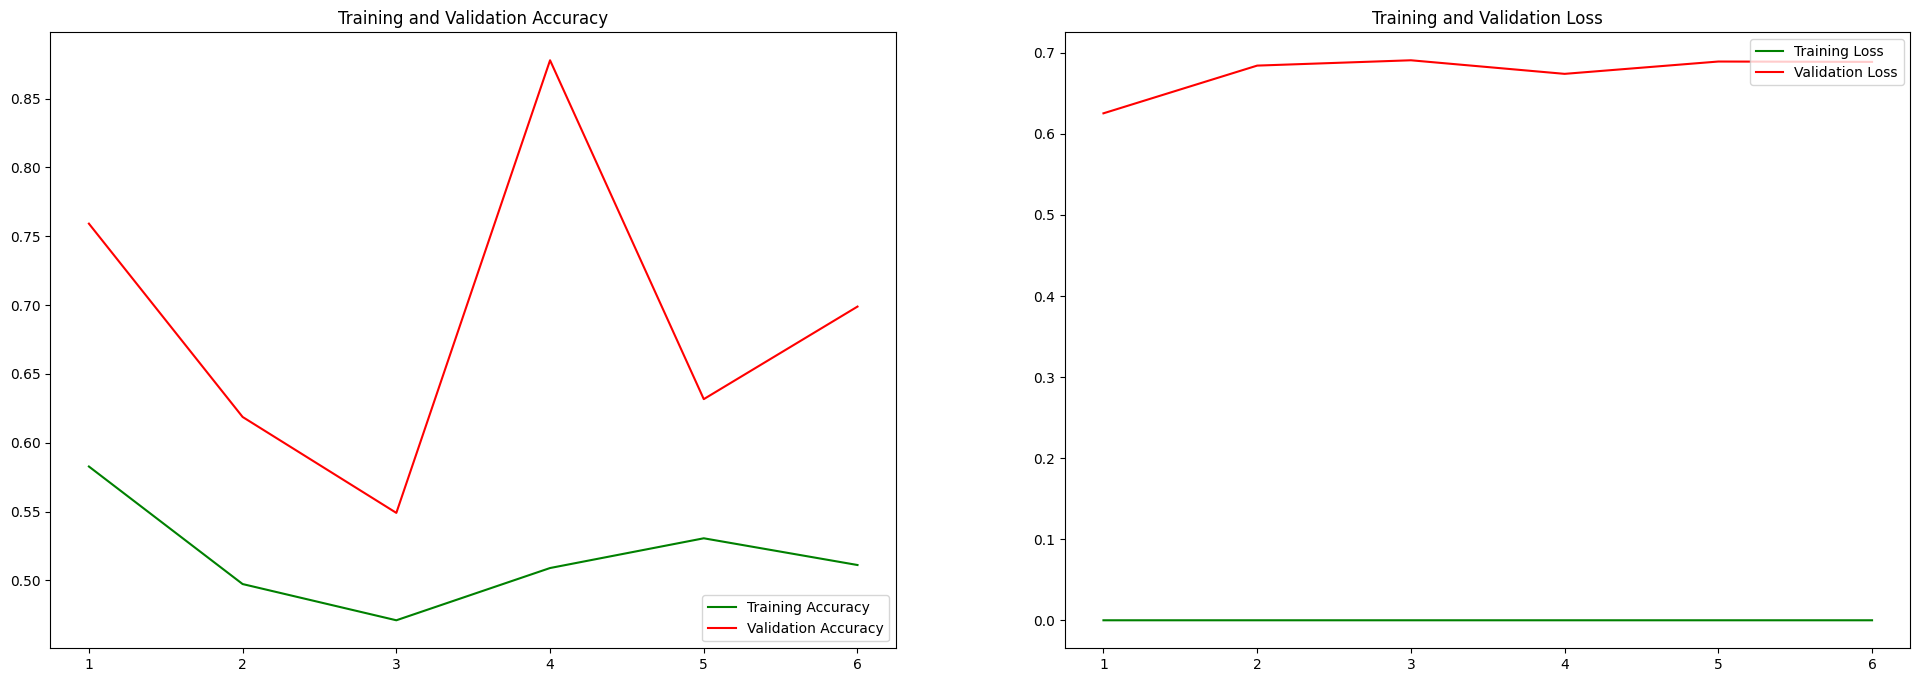

1440/1440 [==============================] - 12s 8ms/step - loss: 0.6834 - binary_accuracy: 0.5833
Validation Binary Accuracy is: 0.76
Testing Binary Accuracy is: 0.58


In [ ]:
# Load and Evaluate Model
model_3, history_3 = evaluate_model(model_3_filepath, 
                         history_3_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_3_evaluation.pdf')

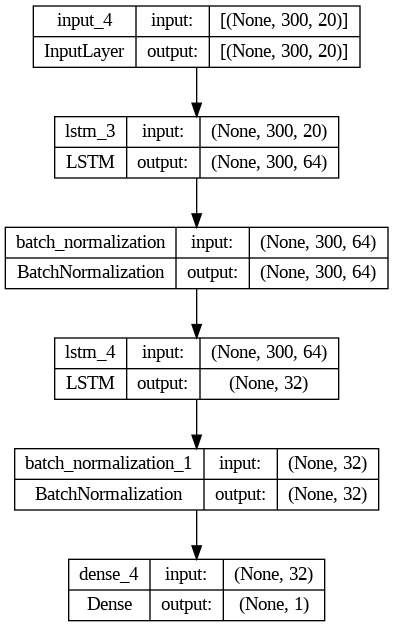

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_3, to_file='models/model_3_arch.png', show_shapes=True, show_layer_names=True)

4800/4800 [==============================] - 36s 7ms/step


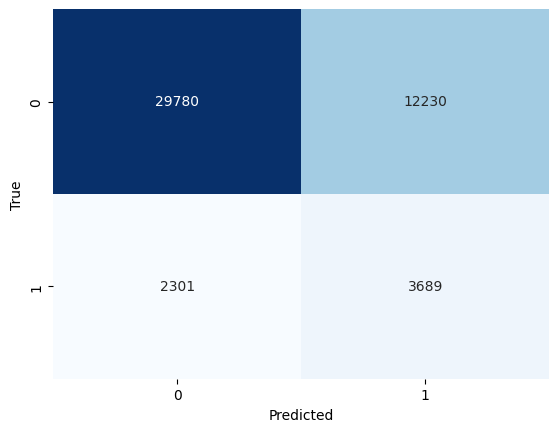

4800/4800 [==============================] - 36s 7ms/step
              precision    recall  f1-score       support
0              0.928275  0.708879  0.803876  42010.000000
1              0.231736  0.615860  0.336757   5990.000000
accuracy       0.697271  0.697271  0.697271      0.697271
macro avg      0.580005  0.662369  0.570316  48000.000000
weighted avg   0.841353  0.697271  0.745584  48000.000000
1590/1590 [==============================] - 12s 8ms/step


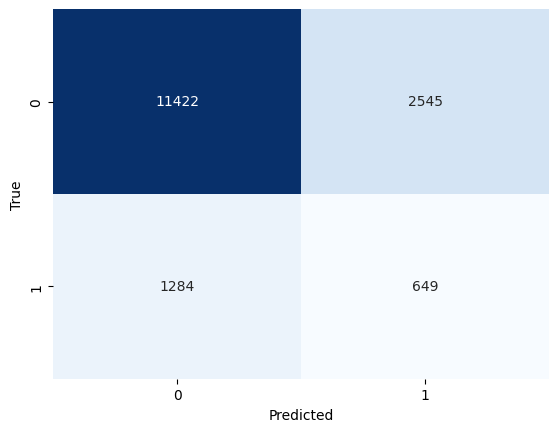

1590/1590 [==============================] - 12s 7ms/step
              precision    recall  f1-score       support
0              0.898945  0.817785  0.856447  13967.000000
1              0.203193  0.335748  0.253169   1933.000000
accuracy       0.759182  0.759182  0.759182      0.759182
macro avg      0.551069  0.576766  0.554808  15900.000000
weighted avg   0.814361  0.759182  0.783105  15900.000000
1440/1440 [==============================] - 11s 7ms/step


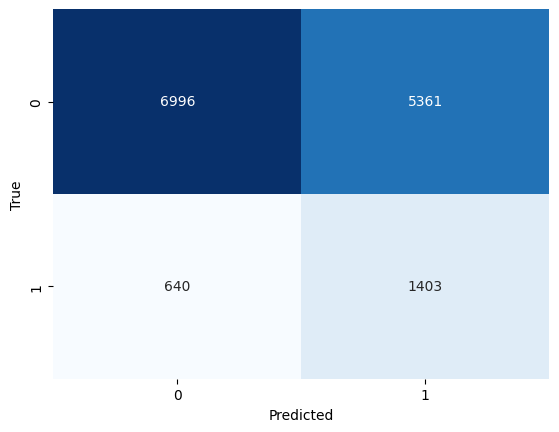

1440/1440 [==============================] - 11s 7ms/step
              precision    recall  f1-score       support
0              0.916186  0.566157  0.699845  12357.000000
1              0.207422  0.686735  0.318610   2043.000000
accuracy       0.583264  0.583264  0.583264      0.583264
macro avg      0.561804  0.626446  0.509228  14400.000000
weighted avg   0.815630  0.583264  0.645757  14400.000000


In [ ]:
confusion_matrix_plot(model_3, train_gen, save_file='models/evaluate/model_3_train_confusion_matrix.pdf')
classification_report_output(model_3, train_gen, save_file=None)
confusion_matrix_plot(model_3, val_gen, save_file='models/evaluate/model_3_val_confusion_matrix.pdf')
classification_report_output(model_3, val_gen, save_file=None)
confusion_matrix_plot(model_3, test_gen, save_file='models/evaluate/model_3_test_confusion_matrix.pdf')
classification_report_output(model_3, test_gen, save_file=None)

## Model 4
Model 4 is a combination of a convolutional layer and an LSTM layer. The convolutional layer is used to extract features from the input data. The output of the convolutional layer is then passed through a max pooling layer to reduce the dimensionality of the features. This process is repeated with another convolutional layer and max pooling layer. The output of the last max pooling layer is then fed into the LSTM layer, which can capture the temporal dependencies in the data.

The output of the LSTM layer is then flattened and passed through a dense layer with a ReLU activation function. A dropout layer is added to prevent overfitting, and the final output layer uses a sigmoid activation function for binary classification.

### Evaluation
Model 4 performs poorly for both classes, as it predicts only the non-stress class (class 0) and ignores the stress class (class 1). It has lower precision, recall, and F1-score for the non-stress class compared to the other models. Model 4 is not able to effectively predict the stress instances.

In [ ]:
# Model 4
def build_lstm_conv_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, no_features))

  # Add a 1D convolutional layer to extract features
  x = Conv1D(filters=lstm_units, kernel_size=9, activation='relu', padding='same')(inputs)
  x = MaxPooling1D(pool_size=2)(x)
  x = Conv1D(filters=lstm_units*2, kernel_size=3, activation='relu', padding='same')(x)
  x = MaxPooling1D(pool_size=2)(x)

  # LSTM layer
  x = LSTM(lstm_units, activation='tanh', return_sequences=True)(x)

  # Flatten the output
  x = Flatten()(x)

  # Dense layer
  x = Dense(lstm_units//2, activation='relu')(x)

  # Dropout layer
  x = Dropout(0.5)(x)

  # Add the output layer
  outputs = Dense(1, activation='sigmoid')(x)

  # Create the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model


In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_4_filepath = 'models/model_4_conv_lstm.keras'
history_4_filepath = 'models/trainHistoryDict/model_4_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.01]

In [ ]:
# Fit the model and tune hyperparameters
history_4, model_4, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_conv_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_4_filepath)
# Pickle the Training Fit History
with open(history_4_filepath, 'wb') as file_pi:
    pickle.dump(history_4, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 conv1d (Conv1D)             (None, 300, 64)           11584     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 128)          0         
 1D)                                                             
                                                                 
 ls

1590/1590 [==============================] - 7s 4ms/step - loss: 0.6757 - binary_accuracy: 0.8784


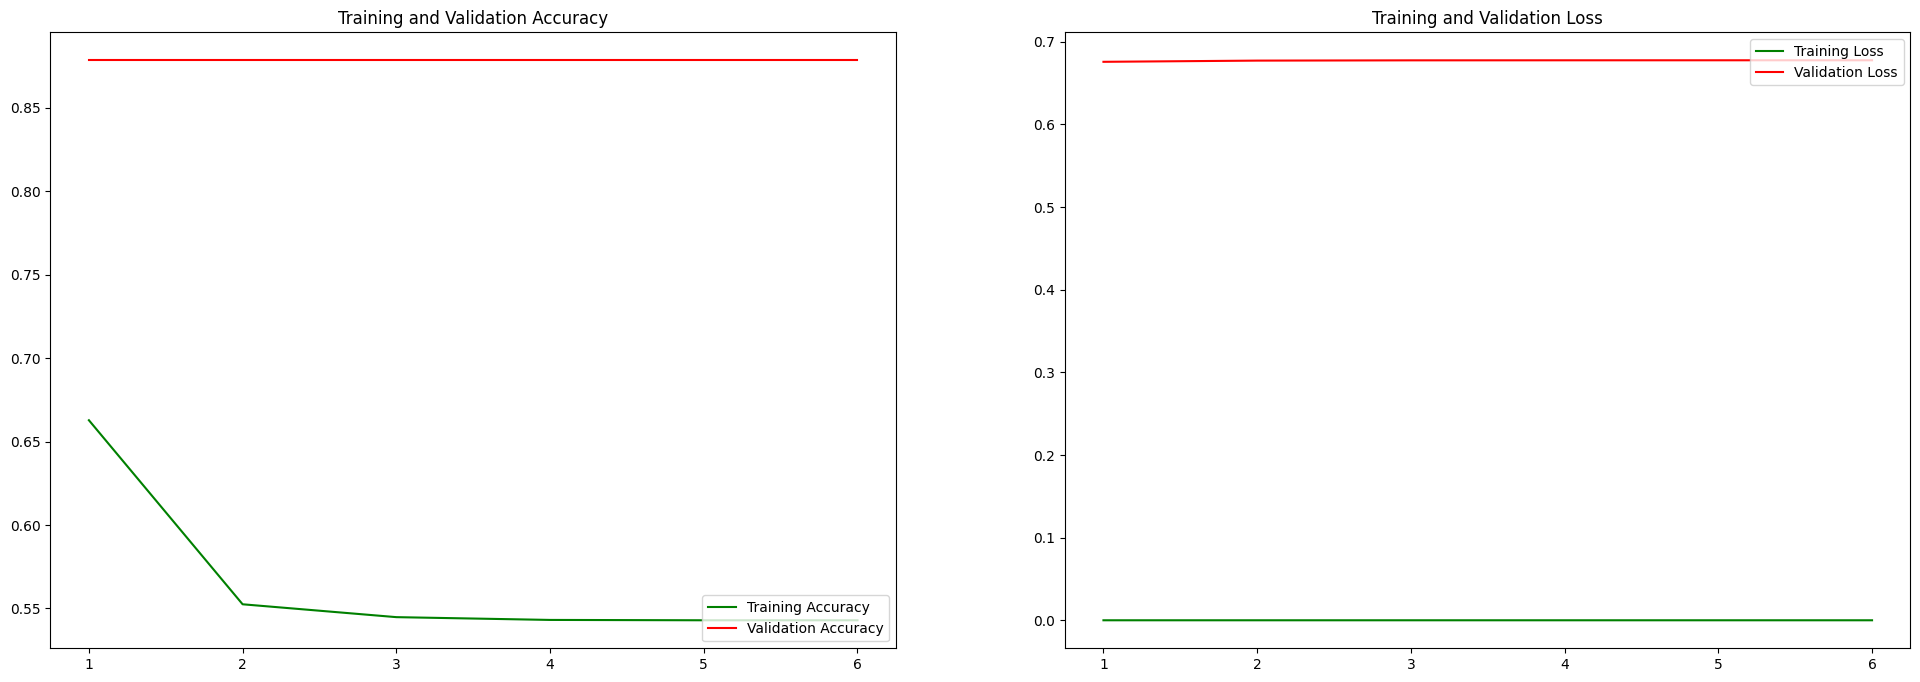

1440/1440 [==============================] - 6s 4ms/step - loss: 0.6767 - binary_accuracy: 0.8581
Validation Binary Accuracy is: 0.88
Testing Binary Accuracy is: 0.86


In [ ]:
# Load and Evaluate Model
model_4, history_4 = evaluate_model(model_4_filepath, 
                         history_4_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_4_evaluation.pdf')

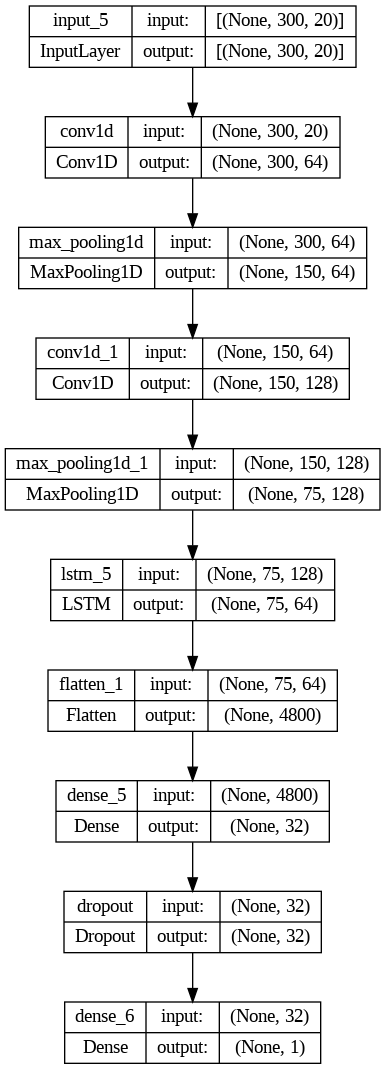

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_4, to_file='models/model_4_arch.png', show_shapes=True, show_layer_names=True)

4800/4800 [==============================] - 14s 3ms/step


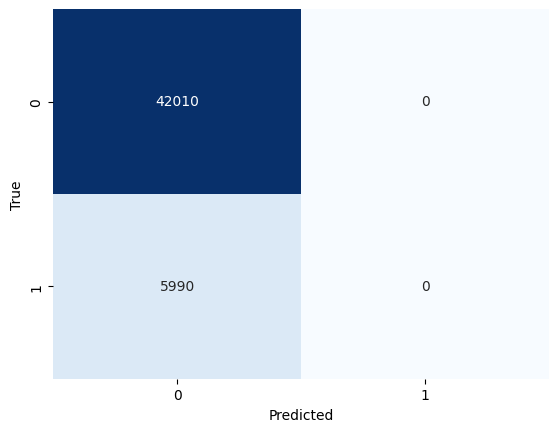

4800/4800 [==============================] - 13s 3ms/step
              precision    recall  f1-score       support
0              0.875208  1.000000  0.933452  42010.000000
1              0.000000  0.000000  0.000000   5990.000000
accuracy       0.875208  0.875208  0.875208      0.875208
macro avg      0.437604  0.500000  0.466726  48000.000000
weighted avg   0.765990  0.875208  0.816965  48000.000000
  39/1590 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1590/1590 [==============================] - 4s 3ms/step


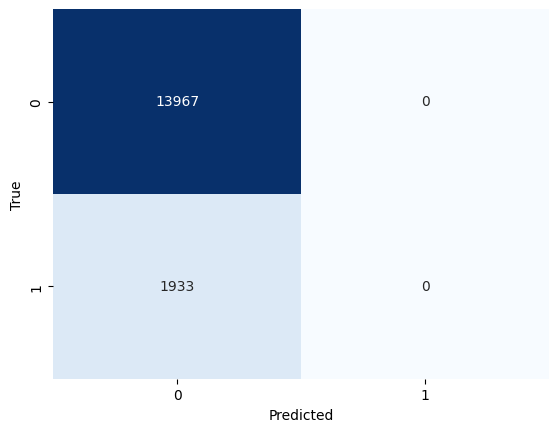

1590/1590 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.878428  1.000000  0.935280  13967.000000
1              0.000000  0.000000  0.000000   1933.000000
accuracy       0.878428  0.878428  0.878428      0.878428
macro avg      0.439214  0.500000  0.467640  15900.000000
weighted avg   0.771635  0.878428  0.821576  15900.000000
  36/1440 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1440/1440 [==============================] - 4s 3ms/step


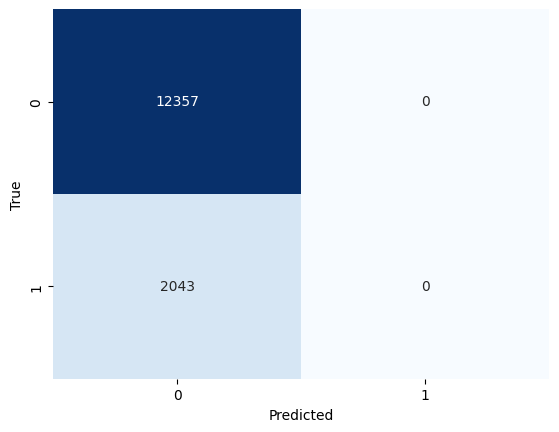

1440/1440 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.858125  1.000000  0.923646  12357.000000
1              0.000000  0.000000  0.000000   2043.000000
accuracy       0.858125  0.858125  0.858125      0.858125
macro avg      0.429063  0.500000  0.461823  14400.000000
weighted avg   0.736379  0.858125  0.792604  14400.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix_plot(model_4, train_gen, save_file='models/evaluate/model_4_train_confusion_matrix.pdf')
classification_report_output(model_4, train_gen, save_file=None)
confusion_matrix_plot(model_4, val_gen, save_file='models/evaluate/model_4_val_confusion_matrix.pdf')
classification_report_output(model_4, val_gen, save_file=None)
confusion_matrix_plot(model_4, test_gen, save_file='models/evaluate/model_4_test_confusion_matrix.pdf')
classification_report_output(model_4, test_gen, save_file=None)

## Model 5
This model, which we will call model 5, is a combination of a Transformer block and an LSTM layer. The Transformer block is designed to learn the dependencies between the time steps of the input sequence and to generate a representation of the input sequence that is more informative and easier to process. The LSTM layer then takes the output of the Transformer block and learns to make predictions based on the temporal dependencies in the input sequence.

The input shape of the model is the same as the previous models, but the key difference is that it utilizes a Transformer block as the initial layer. The Transformer block has shown significant performance improvements over traditional recurrent neural networks like LSTMs, which were used in the previous models.

### Evaluation
Overall, Model 5 performs poorly for both classes, as it predicts only the non-stress class (class 0) and ignores the stress class (class 1). It has lower precision, recall, and F1-score for the non-stress class compared to the other models. Model 5 is not able to effectively predict the stress instances.

In [ ]:
# Model 5: Transformer LSTM
def build_transform_lstm_1(lstm_units, learning_rate):
    from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, TransformerBlock
    from tensorflow.keras.models import Model

    # Define input shape
    input_shape = train_gen[0][0].shape[2]

    # Define input layer
    # Define the input shape
    inputs = Input(seq_length, shape=input_shape)

    # Add transformer block
    transformer_output = TransformerBlock(64, 2)(inputs)

    # Add LSTM layer
    plt.xcorr = LSTM(lstm_units)(transformer_output)

    # Add output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Define model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate), 
                  metrics=['binary_accuracy'])
    
    model.summary()

    return model


In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_5_filepath = 'models/model_5_conv_lstm.keras'
history_5_filepath = 'models/trainHistoryDict/model_5_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.01]

In [ ]:
# Fit the model and tune hyperparameters
history_5, model_5, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_conv_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_5_filepath)
# Pickle the Training Fit History
with open(history_5_filepath, 'wb') as file_pi:
    pickle.dump(history_5, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 300, 64)           11584     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 150, 64)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 150, 128)          24704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 75, 128)          0         
 1D)                                                             
                                                                 
 ls

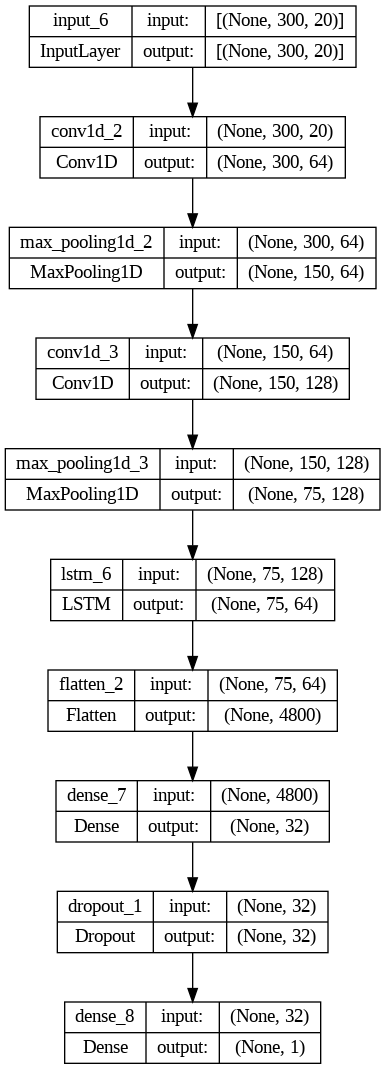

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_5, to_file='models/model_5_arch.png', show_shapes=True, show_layer_names=True)

4800/4800 [==============================] - 13s 3ms/step


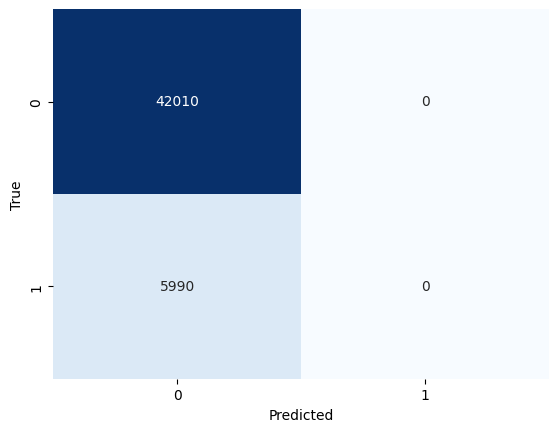

4800/4800 [==============================] - 14s 3ms/step
              precision    recall  f1-score       support
0              0.875208  1.000000  0.933452  42010.000000
1              0.000000  0.000000  0.000000   5990.000000
accuracy       0.875208  0.875208  0.875208      0.875208
macro avg      0.437604  0.500000  0.466726  48000.000000
weighted avg   0.765990  0.875208  0.816965  48000.000000
  39/1590 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1590/1590 [==============================] - 4s 3ms/step


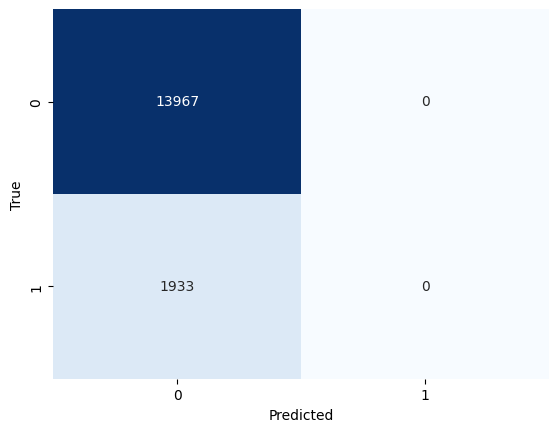

1590/1590 [==============================] - 5s 3ms/step
              precision    recall  f1-score       support
0              0.878428  1.000000  0.935280  13967.000000
1              0.000000  0.000000  0.000000   1933.000000
accuracy       0.878428  0.878428  0.878428      0.878428
macro avg      0.439214  0.500000  0.467640  15900.000000
weighted avg   0.771635  0.878428  0.821576  15900.000000
  38/1440 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1440/1440 [==============================] - 4s 3ms/step


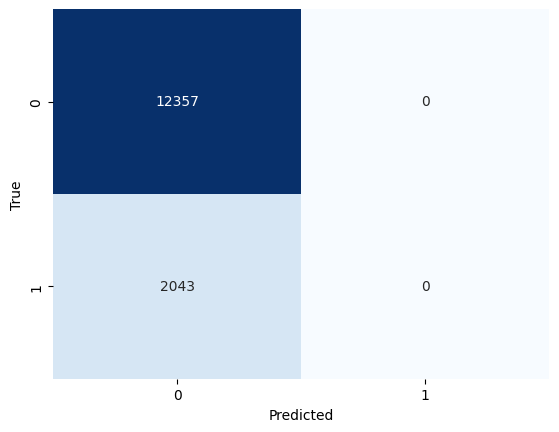

1440/1440 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.858125  1.000000  0.923646  12357.000000
1              0.000000  0.000000  0.000000   2043.000000
accuracy       0.858125  0.858125  0.858125      0.858125
macro avg      0.429063  0.500000  0.461823  14400.000000
weighted avg   0.736379  0.858125  0.792604  14400.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix_plot(model_5, train_gen, save_file='models/evaluate/model_5_train_confusion_matrix.pdf')
classification_report_output(model_5, train_gen, save_file=None)
confusion_matrix_plot(model_5, val_gen, save_file='models/evaluate/model_5_val_confusion_matrix.pdf')
classification_report_output(model_5, val_gen, save_file=None)
confusion_matrix_plot(model_5, test_gen, save_file='models/evaluate/model_5_test_confusion_matrix.pdf')
classification_report_output(model_5, test_gen, save_file=None)

## Model 6
Model 6 is a bidirectional LSTM model which uses an LSTM layer that processes the input sequence in both directions, forward and backward. The model takes the input shape, and then applies two bidirectional LSTM layers, with 50% dropout rate. The final LSTM layer is then connected to a dense layer with a ReLU activation function. Finally, there is an output layer with a sigmoid activation function.

This model differs from the previous models in that it includes a bidirectional LSTM layer. The bidirectional layer allows the model to capture not only the past but also the future context of the input sequence. This is particularly useful when predicting events where future events may influence the final outcome. However, if the prediction solely depends on the past sequence, a bidirectional LSTM may not be the best model for the data.

### Evaluation
The classification report shows that Model 6 performs poorly for both classes. It has low precision, recall, and F1-score for the stress class, indicating that it struggles to correctly predict stress instances. It also has relatively low precision, recall, and F1-score for the non-stress class, indicating that it may have difficulty distinguishing between stress and non-stress instances.

In [ ]:
# Model 6: Bidirectional LSTM
def build_bidirection_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Bidirectional
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, no_features))

  # Next model add a Dense layer here
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         return_sequences=True,
                         dropout=0.5))(inputs)
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         #return_sequences=True,
                         dropout=0.5))(x)
  x = Dense(units=batch_size//2, 
            activation='relu')(x)

  outputs = Dense(units=1, activation='sigmoid')(x)

  # Build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_6_filepath = 'models/model_6_bidirectional.keras'
history_6_filepath = 'models/trainHistoryDict/model_6_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1] #[1, 2, 10, 100, 1000]

In [ ]:
# Fit the model and tune hyperparameters
history_6, model_6, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_bidirection_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_6_filepath)
# Pickle the Training Fit History
with open(history_6_filepath, 'wb') as file_pi:
    pickle.dump(history_6, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         43520     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
 dense_10 (Dense)            (None, 1)                 6         
                                                                 
Tot

1590/1590 [==============================] - 24s 14ms/step - loss: 0.5033 - binary_accuracy: 0.6869


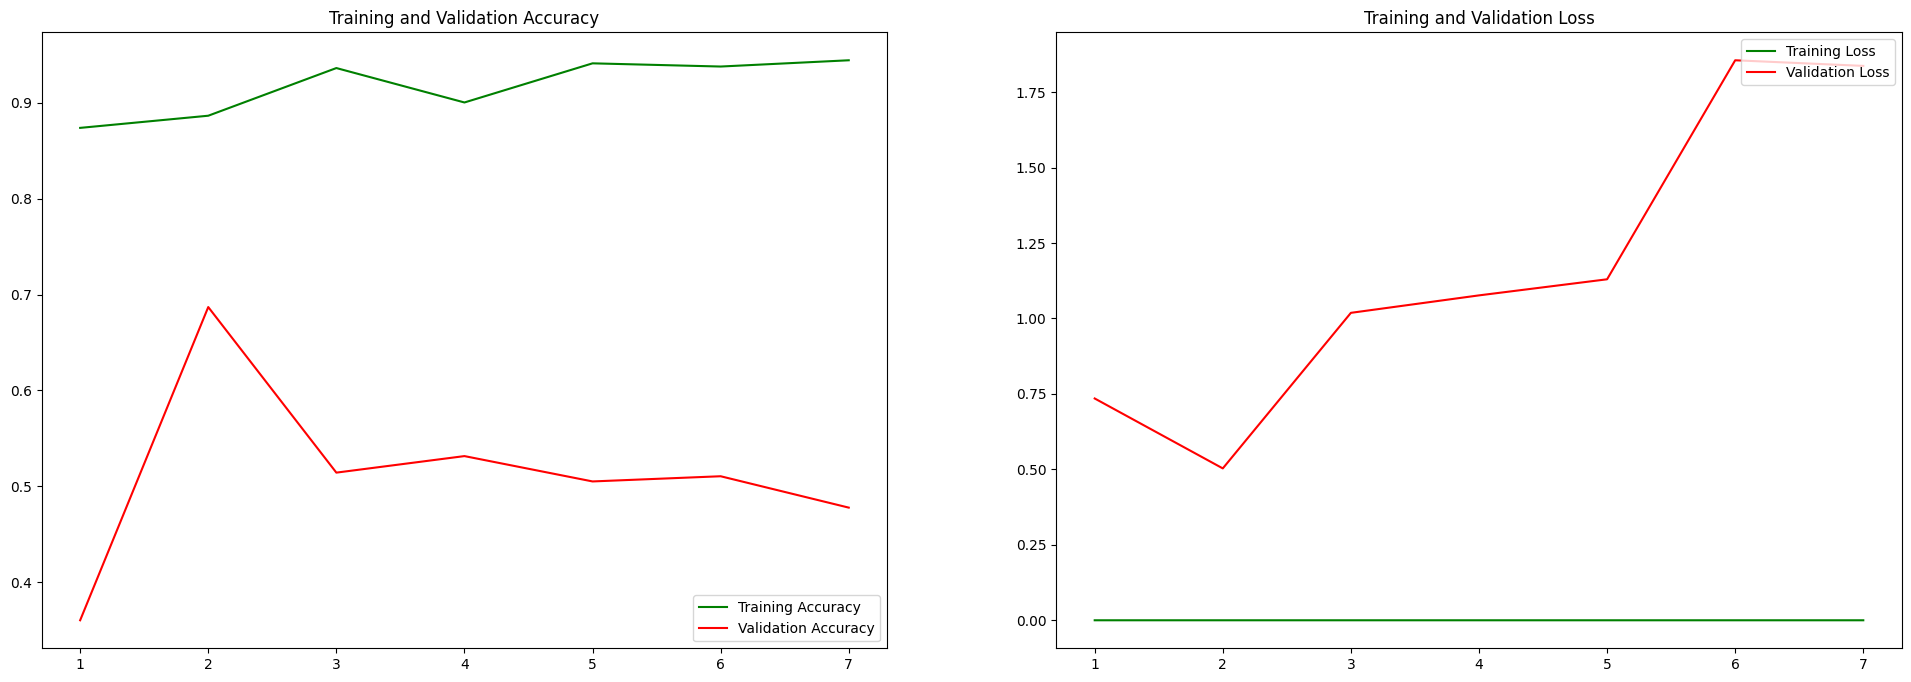

1440/1440 [==============================] - 21s 15ms/step - loss: 0.3687 - binary_accuracy: 0.7607
Validation Binary Accuracy is: 0.69
Testing Binary Accuracy is: 0.76


In [ ]:
# Fit the model to the training data
# Load and Evaluate Model
model_6, history_6 = evaluate_model(model_6_filepath, 
                         history_6_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_6_evaluation.pdf')

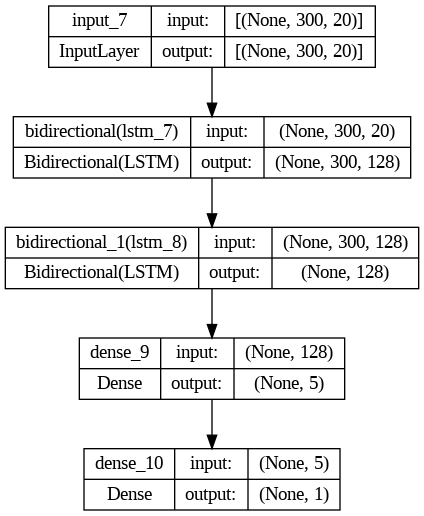

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_6, to_file='models/model_6_arch.png', show_shapes=True, show_layer_names=True)

4800/4800 [==============================] - 66s 13ms/step


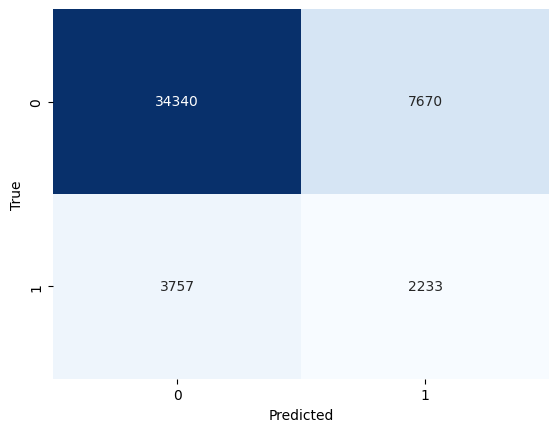

4800/4800 [==============================] - 66s 14ms/step
              precision    recall  f1-score       support
0              0.901383  0.817424  0.857353  42010.000000
1              0.225487  0.372788  0.281004   5990.000000
accuracy       0.761938  0.761938  0.761938      0.761938
macro avg      0.563435  0.595106  0.569179  48000.000000
weighted avg   0.817037  0.761938  0.785430  48000.000000
1590/1590 [==============================] - 22s 14ms/step


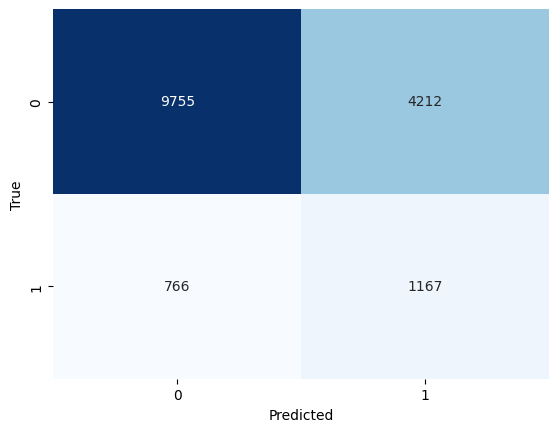

1590/1590 [==============================] - 22s 14ms/step
              precision    recall  f1-score       support
0              0.927193  0.698432  0.796717  13967.000000
1              0.216955  0.603725  0.319201   1933.000000
accuracy       0.686918  0.686918  0.686918      0.686918
macro avg      0.572074  0.651078  0.557959  15900.000000
weighted avg   0.840848  0.686918  0.738664  15900.000000
1440/1440 [==============================] - 20s 14ms/step


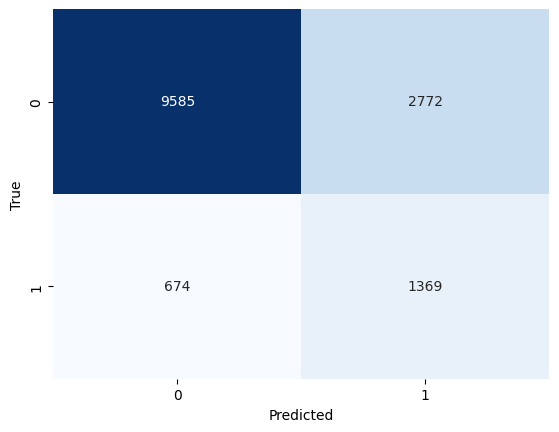

1440/1440 [==============================] - 20s 14ms/step
              precision    recall  f1-score       support
0              0.934302  0.775674  0.847630  12357.000000
1              0.330596  0.670093  0.442755   2043.000000
accuracy       0.760694  0.760694  0.760694      0.760694
macro avg      0.632449  0.722883  0.645193  14400.000000
weighted avg   0.848651  0.760694  0.790188  14400.000000


In [ ]:
confusion_matrix_plot(model_6, train_gen, save_file='models/evaluate/model_6_train_confusion_matrix.pdf')
classification_report_output(model_6, train_gen, save_file=None)
confusion_matrix_plot(model_6, val_gen, save_file='models/evaluate/model_6_val_confusion_matrix.pdf')
classification_report_output(model_6, val_gen, save_file=None)
confusion_matrix_plot(model_6, test_gen, save_file='models/evaluate/model_6_test_confusion_matrix.pdf')
classification_report_output(model_6, test_gen, save_file=None)

## Model 7
Model 7 is a timeseries classification model that uses a transformer architecture. The transformer encoder is composed of a normalization and attention layer, followed by a feedforward neural network. The attention layer is applied to the inputs twice, and a residual connection is added to the output. The feedforward part consists of a convolutional layer and another residual connection. The global average pooling layer is added after the transformer blocks, followed by a fully connected network with a single output. 

Compared to the previous models, model 7 uses a transformer architecture instead of LSTM layers, which may be better suited for timeseries classification tasks. Additionally, it uses a multi-head attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. Finally, it uses global average pooling instead of LSTM or bidirectional LSTM layers, which reduces the number of parameters in the model and can help prevent overfitting.

### Evaluation

Model 7 performs poorly for both classes. It has low precision, recall, and F1-score for the non-stress class, indicating that it fails to predict non-stress instances. It has high recall for the stress class, but very low precision and F1-score, indicating that it incorrectly predicts many instances as stress. This is because it is only predicing the stress class (class 1).

In [ ]:
'''
Model_7: Timeseries classification with a transformer model
'''
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(seq_length, no_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Build model
model_7 = build_transformer_model(
                seq_length,
                n_classes=1,
                head_size=256,
                num_heads=4, # Number of Transformer repeats
                ff_dim=4,
                num_transformer_blocks=4,
                mlp_units=[128],
                mlp_dropout=0.4,
                dropout=0.5,
)
best_learning_rate = 0.001

# Compile Model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"],
)
model_7.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 300, 20)]    0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 300, 20)     40          ['input_8[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 300, 20)     85012       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                            

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_7_filepath = 'models/model_7_transformer.keras'
history_7_filepath = 'models/trainHistoryDict/model_7_history.pkl'

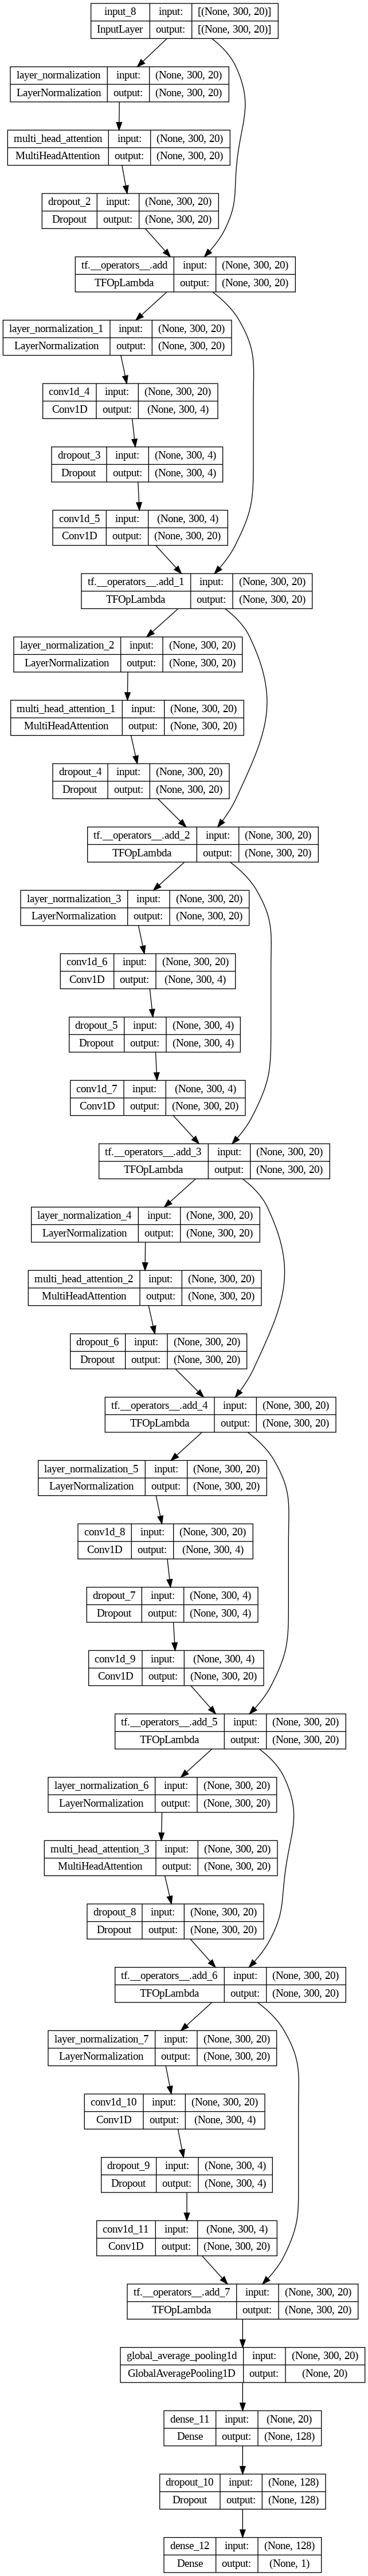

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_7, to_file='models/model_7_arch.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Fit the model to the training data
history_7 = model_7.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_7_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_7_filepath, 'wb') as file_pi:
    pickle.dump(history_7, file_pi)

Epoch 1/200
4800/4800 [==============================] - 231s 45ms/step - loss: 1.2382e-05 - binary_accuracy: 0.1248 - val_loss: 17.8575 - val_binary_accuracy: 0.1216
Epoch 2/200
4800/4800 [==============================] - 217s 45ms/step - loss: 1.7404e-05 - binary_accuracy: 0.1248 - val_loss: 1.6641 - val_binary_accuracy: 0.1216
Epoch 3/200
4800/4800 [==============================] - 216s 45ms/step - loss: 1.7328e-05 - binary_accuracy: 0.1248 - val_loss: 13.0358 - val_binary_accuracy: 0.1216
Epoch 4/200
4800/4800 [==============================] - 216s 45ms/step - loss: 2.7016e-05 - binary_accuracy: 0.1248 - val_loss: 0.9621 - val_binary_accuracy: 0.1216
Epoch 5/200
4800/4800 [==============================] - 215s 45ms/step - loss: 1.6603e-05 - binary_accuracy: 0.1248 - val_loss: 2.2355 - val_binary_accuracy: 0.1216
Epoch 6/200
4800/4800 [==============================] - 216s 45ms/step - loss: 1.5391e-05 - binary_accuracy: 0.1248 - val_loss: 2.6232 - val_binary_accuracy: 0.1216
Ep

1590/1590 [==============================] - 24s 15ms/step - loss: 0.9621 - binary_accuracy: 0.1216


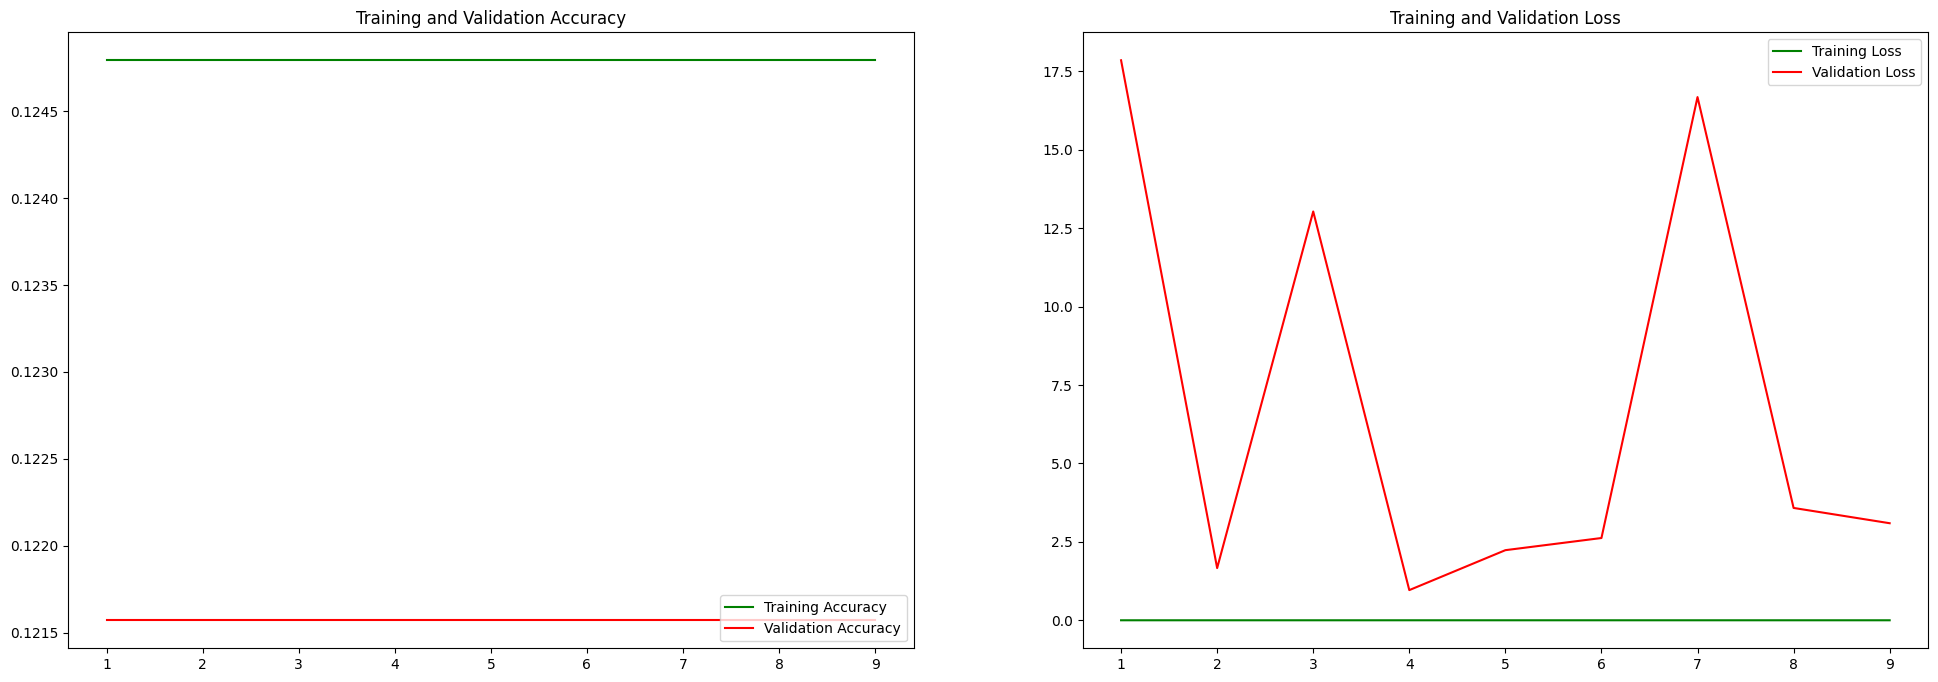

1440/1440 [==============================] - 21s 15ms/step - loss: 0.6001 - binary_accuracy: 0.1419
Validation Binary Accuracy is: 0.12
Testing Binary Accuracy is: 0.14


In [ ]:
# Load and Evaluate Model
model_7, history_7 = evaluate_model(model_7_filepath, 
                         history_7_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_7_evaluation.pdf')

4800/4800 [==============================] - 66s 14ms/step


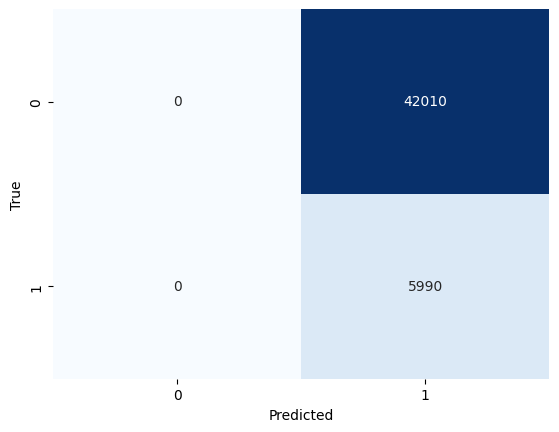

4800/4800 [==============================] - 65s 13ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  42010.000000
1              0.124792  1.000000  0.221893   5990.000000
accuracy       0.124792  0.124792  0.124792      0.124792
macro avg      0.062396  0.500000  0.110946  48000.000000
weighted avg   0.015573  0.124792  0.027690  48000.000000
   4/1590 [..............................] - ETA: 29s 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1590/1590 [==============================] - 21s 13ms/step


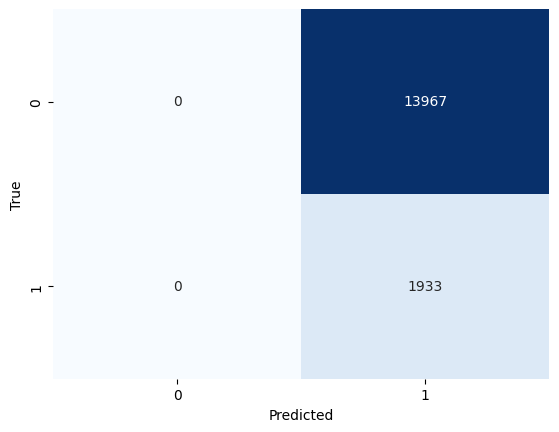

1590/1590 [==============================] - 21s 13ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  13967.000000
1              0.121572  1.000000  0.216789   1933.000000
accuracy       0.121572  0.121572  0.121572      0.121572
macro avg      0.060786  0.500000  0.108395  15900.000000
weighted avg   0.014780  0.121572  0.026356  15900.000000
   6/1440 [..............................] - ETA: 16s 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1440/1440 [==============================] - 19s 13ms/step


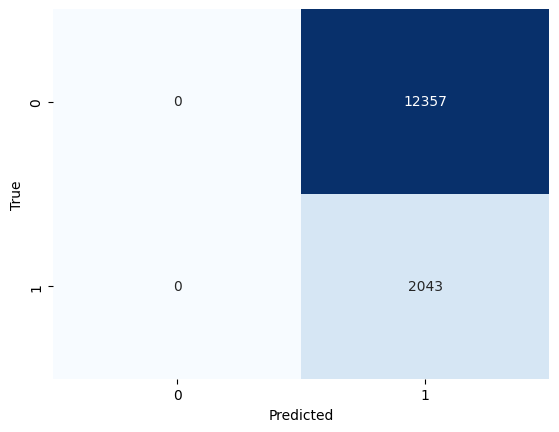

1440/1440 [==============================] - 19s 13ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  12357.000000
1              0.141875  1.000000  0.248495   2043.000000
accuracy       0.141875  0.141875  0.141875      0.141875
macro avg      0.070938  0.500000  0.124247  14400.000000
weighted avg   0.020129  0.141875  0.035255  14400.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix_plot(model_7, train_gen, save_file='models/evaluate/model_7_train_confusion_matrix.pdf')
classification_report_output(model_7, train_gen, save_file=None)
confusion_matrix_plot(model_7, val_gen, save_file='models/evaluate/model_7_val_confusion_matrix.pdf')
classification_report_output(model_7, val_gen, save_file=None)
confusion_matrix_plot(model_7, test_gen, save_file='models/evaluate/model_7_test_confusion_matrix.pdf')
classification_report_output(model_7, test_gen, save_file=None)

## Model 8
This architecture combines the strengths of LSTM and Transformer layers. The LSTM layer captures sequential patterns, while the Transformer blocks enable the model to learn both local and global dependencies in the timeseries data. This combination can potentially improve the model's ability to detect stress patterns in the input timeseries.


### Evaluation
Model 8 performs very poorly for the stress classe. It fails to predict any instances of stress correctly, as it only predicts the normal state (class 0).

In [ ]:
# Model 8
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_lstm_model(input_shape, n_classes, head_size, num_heads, ff_dim, num_transformer_blocks, lstm_units, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # LSTM layer
    lstm_out = layers.LSTM(lstm_units, return_sequences=True)(x)

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(lstm_out, head_size, num_heads, ff_dim, dropout)

    # Flatten and MLP layers
    x = layers.Flatten()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Define model hyperparameters
seq_length = 300
n_classes = 1
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
lstm_units = 64
mlp_units = [128]
mlp_dropout = 0.4
dropout = 0.5

# Build the model
model_8 = build_transformer_lstm_model(
    input_shape=(seq_length, train_gen[0][0].shape[2]),
    n_classes=n_classes,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    lstm_units=lstm_units,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

# Compile the model
best_learning_rate = 0.001
model_8.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"]
)

# Print the model summary
model_8.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300, 20)]    0           []                               
                                                                                                  
 lstm_9 (LSTM)                  (None, 300, 64)      21760       ['input_9[0][0]']                
                                                                                                  
 layer_normalization_14 (LayerN  (None, 300, 64)     128         ['lstm_9[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 300, 64)     265280      ['layer_normalization_14[0]

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_8_filepath = 'models/model_8_transformer.keras'
history_8_filepath = 'models/trainHistoryDict/model_8_history.pkl'

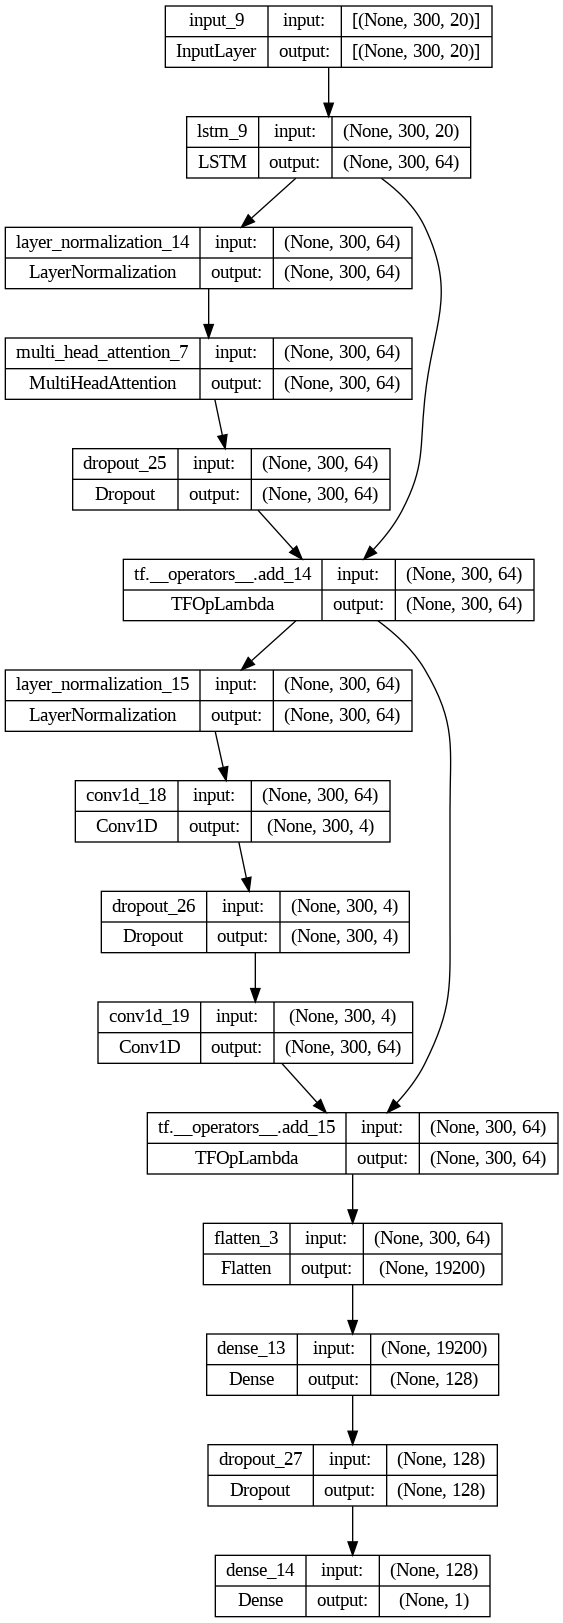

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_8, to_file='models/model_8_arch.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Fit the model to the training data
history_8 = model_8.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_8_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_8_filepath, 'wb') as file_pi:
    pickle.dump(history_8, file_pi)

Epoch 1/200
4800/4800 [==============================] - 110s 22ms/step - loss: 8.3306e-04 - binary_accuracy: 0.8017 - val_loss: 3597.5811 - val_binary_accuracy: 0.4779
Epoch 2/200
4800/4800 [==============================] - 103s 22ms/step - loss: 4.2024e-05 - binary_accuracy: 0.6275 - val_loss: 1.4618 - val_binary_accuracy: 0.8757
Epoch 3/200
4800/4800 [==============================] - 102s 21ms/step - loss: 2.8915e-05 - binary_accuracy: 0.5575 - val_loss: 2.3882 - val_binary_accuracy: 0.8750
Epoch 4/200
4800/4800 [==============================] - 103s 21ms/step - loss: 2.8911e-05 - binary_accuracy: 0.5456 - val_loss: 2.3887 - val_binary_accuracy: 0.8750
Epoch 5/200
4800/4800 [==============================] - 103s 21ms/step - loss: 2.8911e-05 - binary_accuracy: 0.5431 - val_loss: 0.6776 - val_binary_accuracy: 0.8784
Epoch 6/200
4800/4800 [==============================] - 105s 22ms/step - loss: 2.8913e-05 - binary_accuracy: 0.5425 - val_loss: 0.6776 - val_binary_accuracy: 0.8784
E

1590/1590 [==============================] - 14s 8ms/step - loss: 0.6776 - binary_accuracy: 0.8784


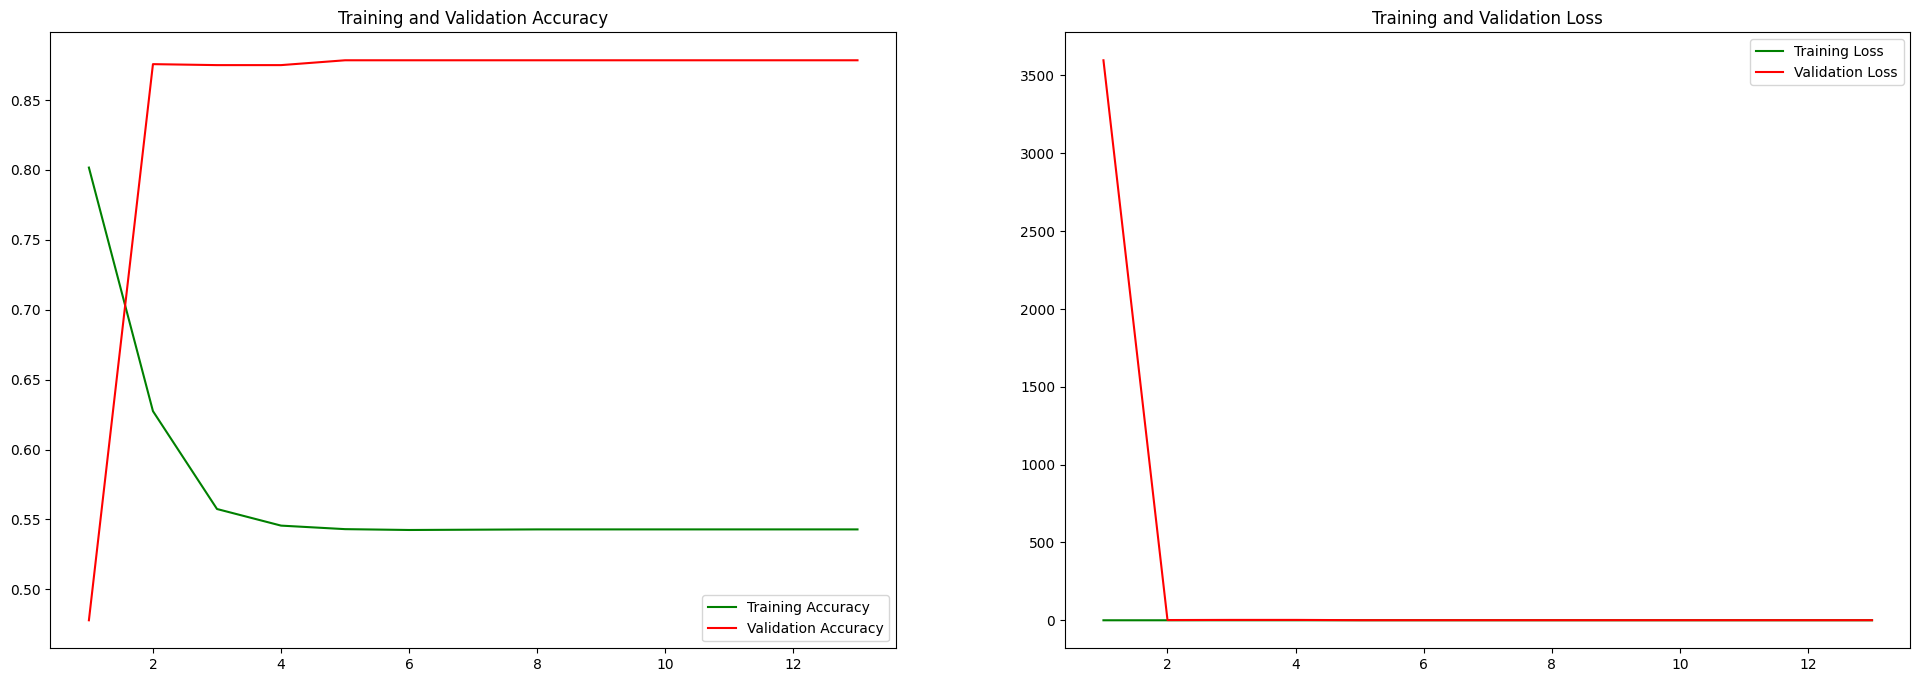

1440/1440 [==============================] - 12s 8ms/step - loss: 0.6784 - binary_accuracy: 0.8581
Validation Binary Accuracy is: 0.88
Testing Binary Accuracy is: 0.86


In [ ]:
# Load and Evaluate Model
model_8, history_8 = evaluate_model(model_8_filepath, 
                         history_8_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_8_evaluation.pdf')

4800/4800 [==============================] - 32s 7ms/step


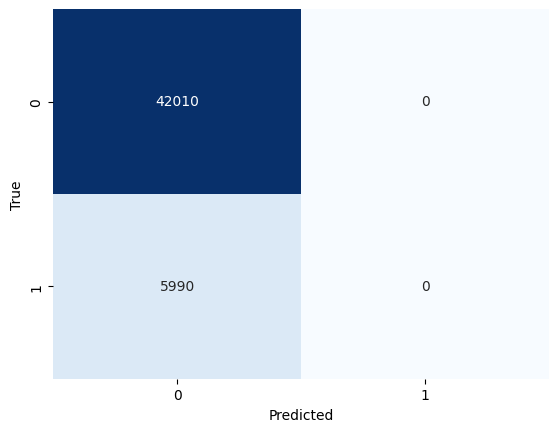

4800/4800 [==============================] - 32s 7ms/step
              precision    recall  f1-score       support
0              0.875208  1.000000  0.933452  42010.000000
1              0.000000  0.000000  0.000000   5990.000000
accuracy       0.875208  0.875208  0.875208      0.875208
macro avg      0.437604  0.500000  0.466726  48000.000000
weighted avg   0.765990  0.875208  0.816965  48000.000000
   6/1590 [..............................] - ETA: 16s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1590/1590 [==============================] - 11s 7ms/step


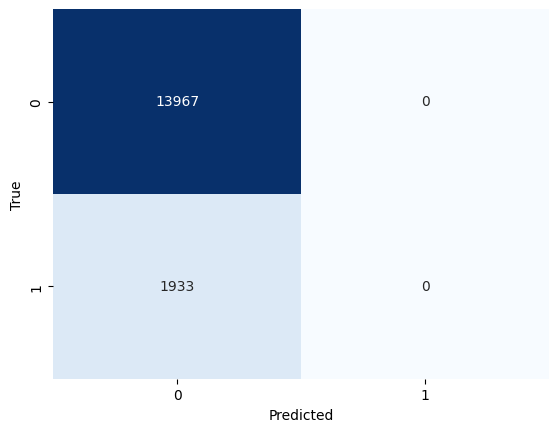

1590/1590 [==============================] - 11s 7ms/step
              precision    recall  f1-score       support
0              0.878428  1.000000  0.935280  13967.000000
1              0.000000  0.000000  0.000000   1933.000000
accuracy       0.878428  0.878428  0.878428      0.878428
macro avg      0.439214  0.500000  0.467640  15900.000000
weighted avg   0.771635  0.878428  0.821576  15900.000000
  15/1440 [..............................] - ETA: 10s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1440/1440 [==============================] - 10s 7ms/step


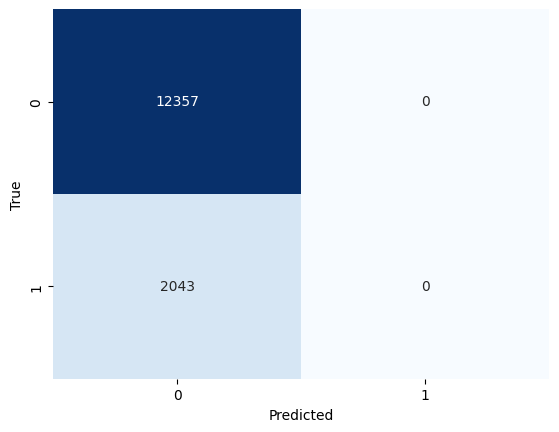

1440/1440 [==============================] - 10s 7ms/step
              precision    recall  f1-score       support
0              0.858125  1.000000  0.923646  12357.000000
1              0.000000  0.000000  0.000000   2043.000000
accuracy       0.858125  0.858125  0.858125      0.858125
macro avg      0.429063  0.500000  0.461823  14400.000000
weighted avg   0.736379  0.858125  0.792604  14400.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix_plot(model_8, train_gen, save_file='models/evaluate/model_8_train_confusion_matrix.pdf')
classification_report_output(model_8, train_gen, save_file=None)
confusion_matrix_plot(model_8, val_gen, save_file='models/evaluate/model_8_val_confusion_matrix.pdf')
classification_report_output(model_8, val_gen, save_file=None)
confusion_matrix_plot(model_8, test_gen, save_file='models/evaluate/model_8_test_confusion_matrix.pdf')
classification_report_output(model_8, test_gen, save_file=None)

## Model 9
This is a valid implementation of the [TS-Transformer](https://arxiv.org/abs/2103.13790) model using the Keras API in TensorFlow. It consists of a combination of an LSTM layer and several Transformer blocks followed by a fully connected layer to perform binary classification. 

The model is defined using the `build_ts_transformer()` function, which takes in the input shape, number of classes, hyperparameters such as head size, number of heads, feedforward dimension, number of transformer blocks, LSTM units, and MLP units.

### Evaluation
Model 9 improves upon model 8 but not by much. Model 9 predicted only a few instances of class 1 correctly. Overall, the model's accuracy is high for classifying non-stress instances (class 0), but it fails to detect instances of stress (class 1).

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define function to build the TS-Transformer model
def build_ts_transformer(input_shape, n_classes, head_size, num_heads, ff_dim, num_transformer_blocks, lstm_units, mlp_units, dropout=0, mlp_dropout=0):
    # LSTM layer
    inputs = keras.Input(shape=input_shape)
    lstm_out = layers.LSTM(lstm_units, return_sequences=True)(inputs)

    # Transformer blocks
    x = lstm_out
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Flatten and MLP layers
    x = layers.Flatten()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Define the hyperparameters
seq_length = 300
n_classes = 1
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
lstm_units = 64
mlp_units = [128]
mlp_dropout = 0.4
dropout = 0.5
epochs = 20
batch_size = 32
learning_rate = 0.001

# Build the model
model_9 = build_ts_transformer(
    input_shape=(seq_length, train_gen[0][0].shape[2]),
    n_classes=n_classes,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    lstm_units=lstm_units,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

# Compile the model
best_learning_rate = 0.001
model_9.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"]
)

# Print the model summary
model_9.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 300, 20)]    0           []                               
                                                                                                  
 lstm_10 (LSTM)                 (None, 300, 64)      21760       ['input_10[0][0]']               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 300, 64)     128         ['lstm_10[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 300, 64)     265280      ['layer_normalization_16[0]

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_9_filepath = 'models/model_9_transformer.keras'
history_9_filepath = 'models/trainHistoryDict/model_9_history.pkl'

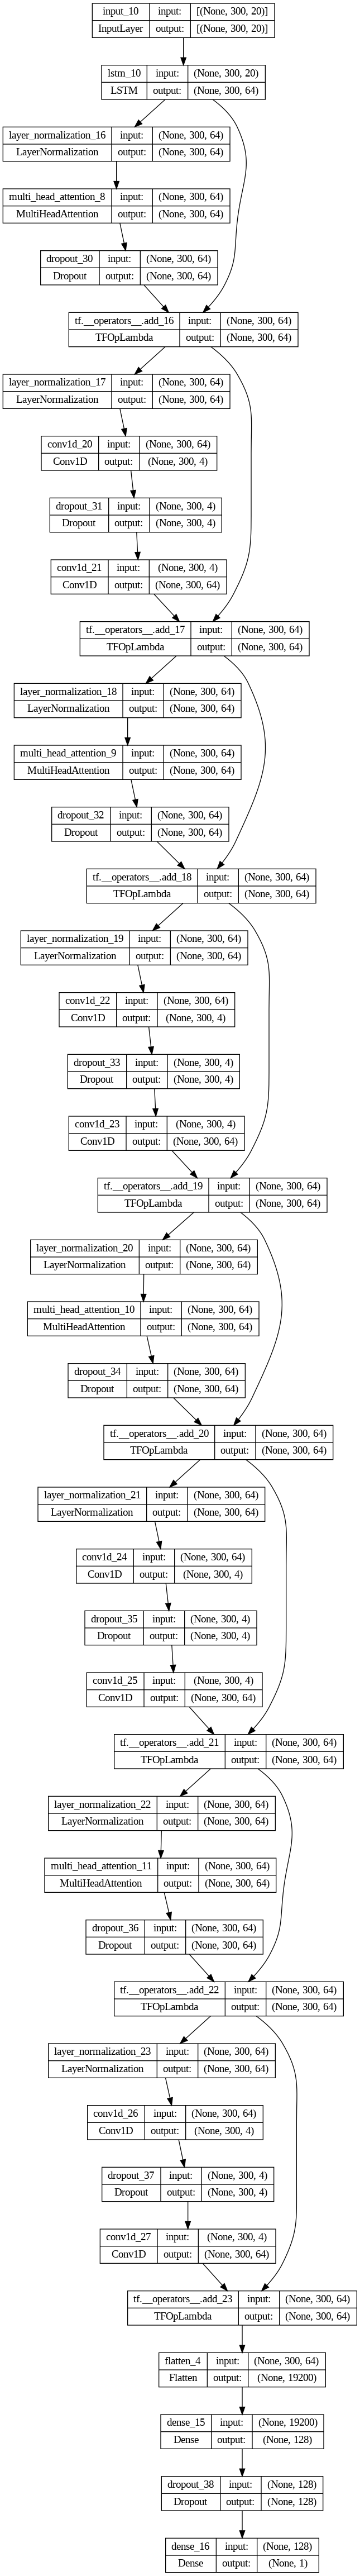

In [ ]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_9, to_file='models/model_8_arch.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Fit the model to the training data
history_9 = model_9.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_9_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_9_filepath, 'wb') as file_pi:
    pickle.dump(history_9, file_pi)

Epoch 1/200
4800/4800 [==============================] - 270s 53ms/step - loss: 0.0057 - binary_accuracy: 0.8497 - val_loss: 0.8269 - val_binary_accuracy: 0.2061
Epoch 2/200
4800/4800 [==============================] - 253s 53ms/step - loss: 3.0539e-05 - binary_accuracy: 0.2303 - val_loss: 0.6956 - val_binary_accuracy: 0.1332
Epoch 3/200
4800/4800 [==============================] - 253s 53ms/step - loss: 2.8953e-05 - binary_accuracy: 0.4083 - val_loss: 0.6726 - val_binary_accuracy: 0.8784
Epoch 4/200
4800/4800 [==============================] - 251s 52ms/step - loss: 1.4335e-04 - binary_accuracy: 0.3478 - val_loss: 0.6797 - val_binary_accuracy: 0.1501
Epoch 5/200
4800/4800 [==============================] - 253s 53ms/step - loss: 2.8838e-05 - binary_accuracy: 0.4253 - val_loss: 0.6646 - val_binary_accuracy: 0.8785
Epoch 6/200
4800/4800 [==============================] - 253s 53ms/step - loss: 2.8847e-05 - binary_accuracy: 0.5069 - val_loss: 0.6615 - val_binary_accuracy: 0.8785
Epoch 7/

1590/1590 [==============================] - 29s 18ms/step - loss: 0.6615 - binary_accuracy: 0.8785


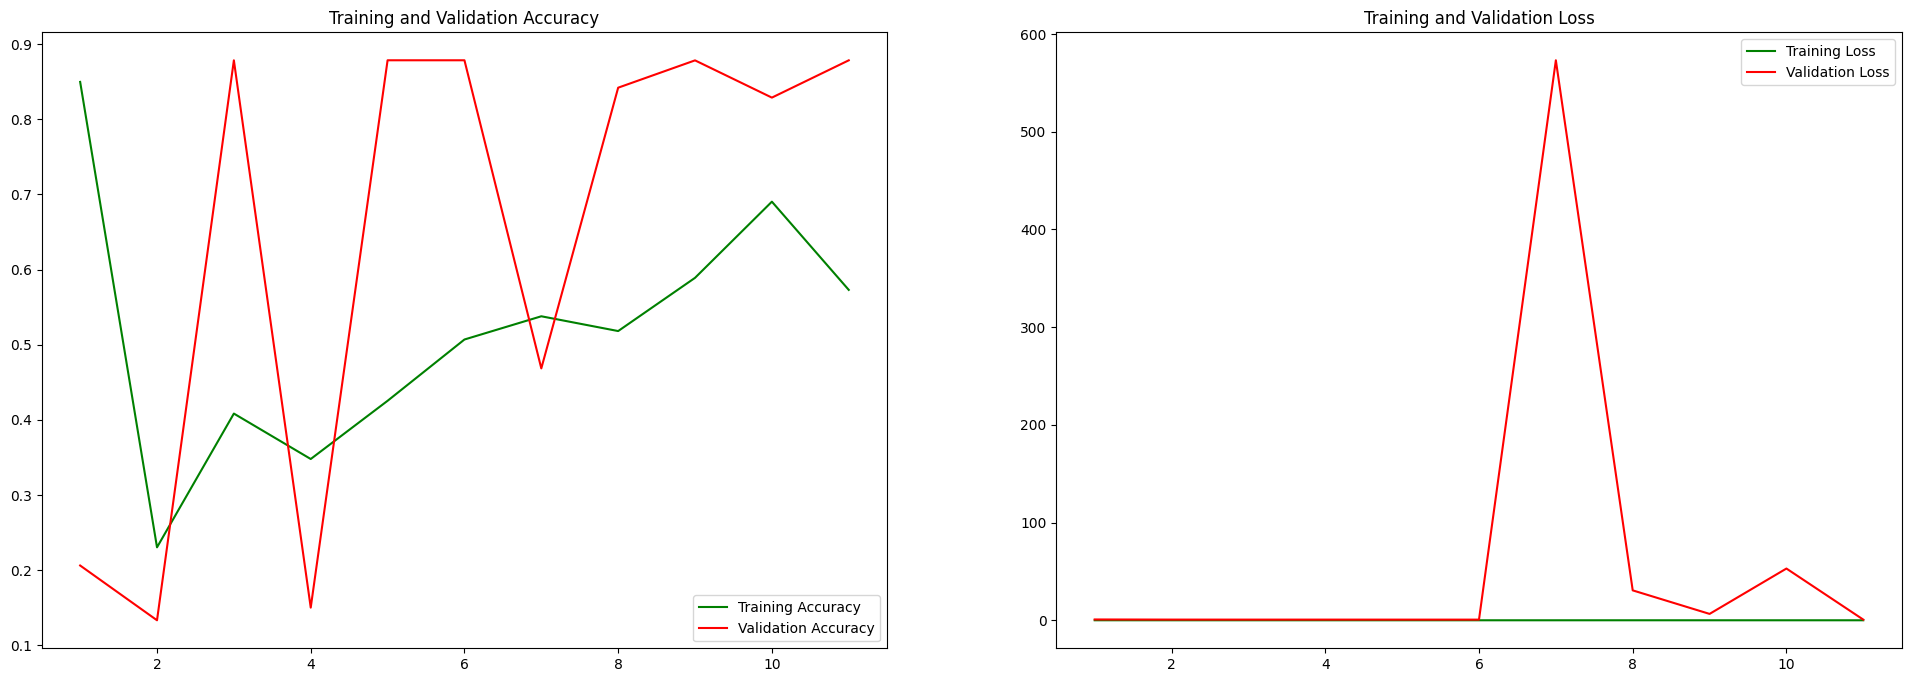

1440/1440 [==============================] - 26s 18ms/step - loss: 0.6778 - binary_accuracy: 0.8581
Validation Binary Accuracy is: 0.88
Testing Binary Accuracy is: 0.86


In [ ]:
model_9, history_9 = evaluate_model(model_9_filepath, 
                         history_9_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_9_evaluation.pdf')

4800/4800 [==============================] - 78s 16ms/step


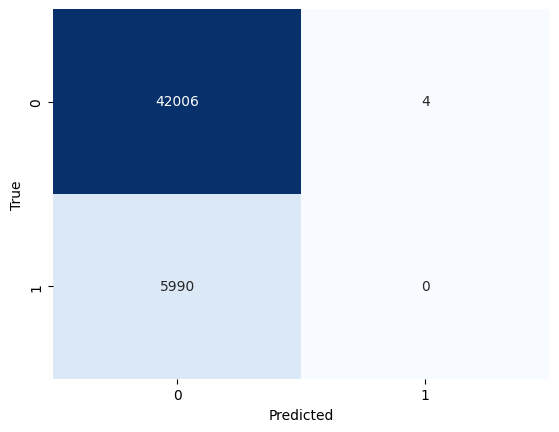

4800/4800 [==============================] - 78s 16ms/step
              precision    recall  f1-score       support
0              0.875198  0.999905  0.933404  42010.000000
1              0.000000  0.000000  0.000000   5990.000000
accuracy       0.875125  0.875125  0.875125      0.875125
macro avg      0.437599  0.499952  0.466702  48000.000000
weighted avg   0.765981  0.875125  0.816923  48000.000000
1590/1590 [==============================] - 26s 16ms/step


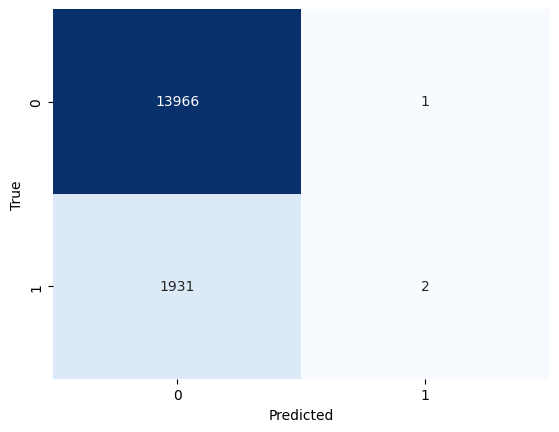

1590/1590 [==============================] - 26s 16ms/step
              precision    recall  f1-score       support
0              0.878531  0.999928  0.935307  13967.000000
1              0.666667  0.001035  0.002066   1933.000000
accuracy       0.878491  0.878491  0.878491      0.878491
macro avg      0.772599  0.500482  0.468686  15900.000000
weighted avg   0.852774  0.878491  0.821850  15900.000000
1440/1440 [==============================] - 23s 16ms/step


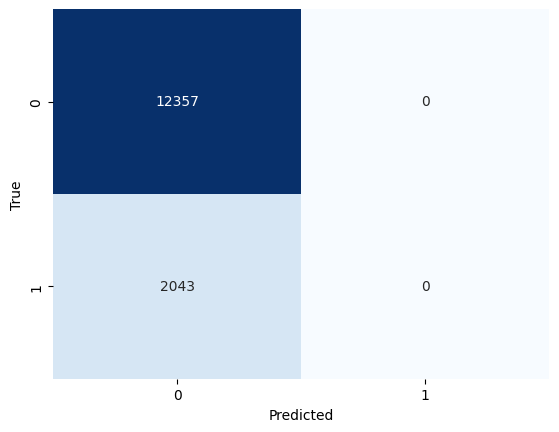

1440/1440 [==============================] - 23s 16ms/step
              precision    recall  f1-score       support
0              0.858125  1.000000  0.923646  12357.000000
1              0.000000  0.000000  0.000000   2043.000000
accuracy       0.858125  0.858125  0.858125      0.858125
macro avg      0.429063  0.500000  0.461823  14400.000000
weighted avg   0.736379  0.858125  0.792604  14400.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix_plot(model_9, train_gen, save_file='models/evaluate/model_9_train_confusion_matrix.pdf')
classification_report_output(model_9, train_gen, save_file=None)
confusion_matrix_plot(model_9, val_gen, save_file='models/evaluate/model_9_val_confusion_matrix.pdf')
classification_report_output(model_9, val_gen, save_file=None)
confusion_matrix_plot(model_9, test_gen, save_file='models/evaluate/model_9_test_confusion_matrix.pdf')
classification_report_output(model_9, test_gen, save_file=None)

## Model 10 XGBoost
XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm that is widely used for various types of predictive modeling tasks. XGBoost is an ensemble learning method that combines the predictions of multiple weak prediction models to create a strong predictive model. It uses a boosting technique, where each subsequent model focuses on correcting the mistakes made by the previous models. This iterative process helps XGBoost to continually improve its predictions.

XGBoost provides a measure of feature importance, which can help you understand which features from the wearable device data are most influential in predicting stress levels. This information can guide feature selection and potentially lead to insights about the underlying factors contributing to stress.

### Evaluation

The XGBoost model performs well overall. The model performs well in terms of accuracy and precision for both the validation and testing sets. The F1-score for the stress class (class 1) is higher than all previous models.

#### Feature Importance
The XGBoost feature importance results indicate that physiological measurements related to heart rate, electrodermal activity, respiration rate, and temperature are important factors for predicting stress using the XGBoost model. The longer-term averages and standard deviations (300-second window) seem to carry more weight in the prediction compared to the shorter-term (60-second window) features.

In [ ]:
# XGBoost and Random Forests
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extract features and labels from the TimeseriesGenerator
X_train = np.concatenate([batch[0] for batch in train_gen])
y_train = np.concatenate([batch[1] for batch in train_gen])

X_val = np.concatenate([batch[0] for batch in val_gen])
y_val = np.concatenate([batch[1] for batch in val_gen])

X_test = np.concatenate([batch[0] for batch in test_gen])
y_test = np.concatenate([batch[1] for batch in test_gen])

# Reshape the data into a 2D format
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [ ]:
X_train_2d.shape

(48000, 6000)

In [ ]:
len(X_train)

48000

In [ ]:
X_train = train_df.drop(['label', 'subject', 'duration'], axis=1)
y_train = train_df['label']

X_val = val_df.drop(['label', 'subject', 'duration'], axis=1)
y_val = val_df['label']

X_test = test_df.drop(['label', 'subject', 'duration'], axis=1)
y_test = test_df['label']

In [ ]:
from sklearn.model_selection import GridSearchCV
import joblib

# Define the hyperparameters to search over
param_grid = {
    'tree_method': ['gpu_hist'],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5],
    'class_weight': [None, class_weights_dict]
}

#Train an XGBoost model:
xgb_model = XGBClassifier(random_state=42)

# Create the GridSearchCV object
model_10 = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    error_score='raise',
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available GPU cores
)

# Fit the GridSearchCV object to the training data
model_10.fit(X_train, y_train)

# Save model
model_10_best = model_10.best_estimator_
joblib.dump(model_10_best, 'models/model_10.pkl')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


['models/model_10.pkl']

In [ ]:
# Print the best hyperparameters and the corresponding validation accuracy
y_train_pred = model_10.predict(X_train)
y_val_pred = model_10.predict(X_val)
y_test_pred = model_10.predict(X_test)
print("Best hyperparameters:", model_10.best_params_)
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

# Print confusion matrix for testing set
print("Confusion matrix (testing set):\n", confusion_matrix(y_test, y_test_pred))

# Print classification report for testing set
print("Classification report (testing set):\n", classification_report(y_test, y_test_pred))

Best hyperparameters: {'class_weight': None, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'tree_method': 'gpu_hist'}
Train accuracy: 0.998991769547325
Validation accuracy: 0.9194545454545454
Confusion matrix (training set):
 [[42583    27]
 [   22  5968]]
Classification report (training set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42610
           1       1.00      1.00      1.00      5990

    accuracy                           1.00     48600
   macro avg       1.00      1.00      1.00     48600
weighted avg       1.00      1.00      1.00     48600

Confusion matrix (validation set):
 [[13686   881]
 [  448  1485]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.97      0.94      0.95     14567
           1       0.63      0.77      0.69      1933

    accuracy                           0.92     16500
   macro avg       0.80      0.85     

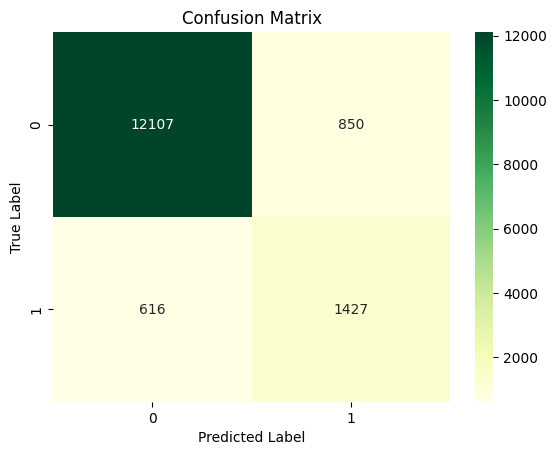

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model_10.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='YlGn', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('models/evaluate/model_10_confusion_matrix.png')

                feature  importance
7   EDA_Phasic_std_300s       145.0
10   ECG_Rate_mean_300s       145.0
14       Temp_mean_300s        93.0
8     ECG_Rate_mean_60s        86.0
5     RSP_Rate_std_300s        67.0
4    RSP_Rate_mean_300s        65.0
15        Temp_std_300s        64.0
11    ECG_Rate_std_300s        57.0
6    EDA_Phasic_std_60s        55.0
12        Temp_mean_60s        50.0


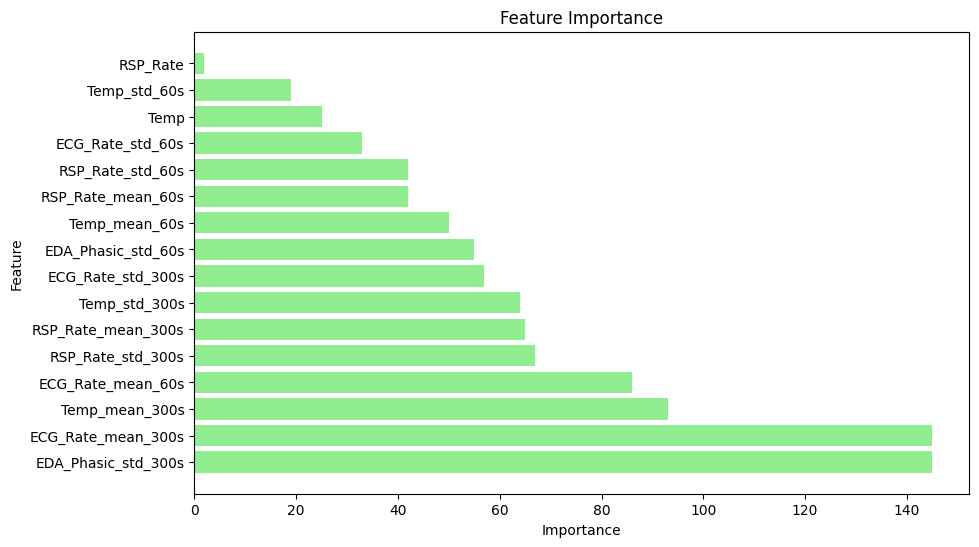

In [ ]:
# Feature Importance
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Disable all warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Get the booster object
booster = model_10.best_estimator_.get_booster()

# Get the feature importance scores
feature_importances = booster.get_score(importance_type="weight")

# Create a dataframe to store the feature importance scores
fi_df = pd.DataFrame({'feature': list(feature_importances.keys()), 
                      'importance': list(feature_importances.values())})

# Sort the dataframe by feature importance scores in descending order
fi_df = fi_df.sort_values(by='importance', ascending=False)

# Print the top ten most important features
print(fi_df.head(10))

# Create a bar graph of feature importance
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Save the plot as a PNG image
plt.savefig('img/feature_importance.png', dpi=300, bbox_inches='tight')

## Model 11
The Random Forest model is a powerful machine learning algorithm that can be used for classification tasks, such as forecasting stress using wearable device data. Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. Each decision tree is built independently on different subsets of the data, and the final prediction is made by aggregating the predictions of all individual trees. This ensemble approach helps improve the model's accuracy and robustness.

### Evaluation
Model 11 performed better in recall and F1-score compared to all previous models.

### Feature importance
Similar to model 10 (XGBoost), model 11 indicates the most important features are the extracted statistical features for mean heart rate (ECG) and electrodermal activity over 5-min and 1-min intervals.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'class_weight': [None, class_weights_dict]
}

# Create a RandomForestClassifier object
rf_model = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
model_11 = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available cores
)

# Fit the GridSearchCV object to the training data
model_11.fit(X_train, y_train)



Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None,
                                          {0: 2.346866932644919e-05,
                                           1: 0.0001669449081803005}],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=3)

In [ ]:
# Print the best hyperparameters and the corresponding validation accuracy
y_train_pred = model_11.predict(X_train)
y_val_pred = model_11.predict(X_val)
y_test_pred = model_11.predict(X_test)
print("Best hyperparameters:", model_11.best_params_)
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

# Print confusion matrix for testing set
print("Confusion matrix (testing set):\n", confusion_matrix(y_test, y_test_pred))

# Print classification report for testing set
print("Classification report (testing set):\n", classification_report(y_test, y_test_pred))

Best hyperparameters: {'class_weight': {0: 2.346866932644919e-05, 1: 0.0001669449081803005}, 'max_depth': 9, 'n_estimators': 100}
Train accuracy: 0.9822633744855968
Validation accuracy: 0.8909090909090909
Confusion matrix (training set):
 [[41748   862]
 [    0  5990]]
Classification report (training set):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     42610
           1       0.87      1.00      0.93      5990

    accuracy                           0.98     48600
   macro avg       0.94      0.99      0.96     48600
weighted avg       0.98      0.98      0.98     48600

Confusion matrix (validation set):
 [[13588   979]
 [  821  1112]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.94      0.93      0.94     14567
           1       0.53      0.58      0.55      1933

    accuracy                           0.89     16500
   macro avg       0.74      0.75     

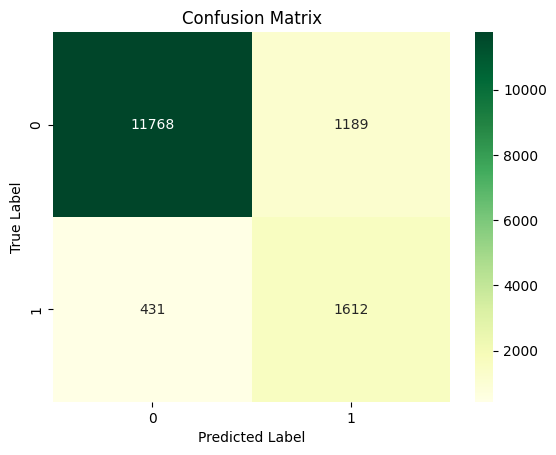

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model_11.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='YlGn', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('models/evaluate/model_11_confusion_matrix.png')

                     importance
ECG_Rate_mean_300s     0.194850
EDA_Phasic_std_300s    0.181640
ECG_Rate_mean_60s      0.149783
ECG_Rate_std_300s      0.090755
EDA_Phasic_std_60s     0.065071
RSP_Rate_std_300s      0.046917
ECG_Rate               0.040938
Temp_mean_300s         0.036136
Temp_mean_60s          0.035421
RSP_Rate_mean_300s     0.032819


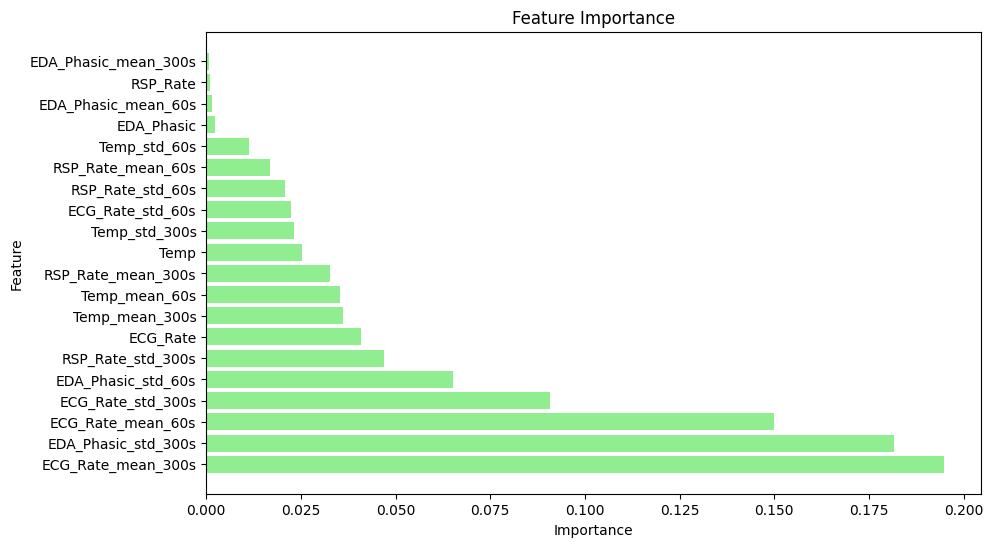

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# Replace 'X' with your actual feature data or feature names
feature_data = X_train  # Replace with your feature data or feature names
feature_names = feature_data.columns.values  # Replace with your feature names

# Get the feature importance scores
feature_importances = model_11.best_estimator_.feature_importances_

# Create a dictionary of feature importance scores with corresponding feature names
feature_scores = dict(zip(feature_names, feature_importances))

# Create a dataframe to store the feature importance scores
fi_df = pd.DataFrame.from_dict(feature_scores, orient='index', columns=['importance'])

# Sort the dataframe by feature importance scores in descending order
fi_df = fi_df.sort_values(by='importance', ascending=False)

# Print the top ten most important features
print(fi_df.head(10))

# Create a bar graph of feature importance
plt.figure(figsize=(10, 6))
plt.barh(fi_df.index, fi_df['importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Save the plot as a PNG image
plt.savefig('models/evaluate/model11_feature_importance.png', dpi=300, bbox_inches='tight')


# Model Evaluation

In [ ]:
def testing_metric_table(models, test_data):
    '''
    This function computes the classification report of multiple models' performance 
    on a given dataset. It iterates over the models, uses each model to predict the labels 
    of the data, and computes the accuracy, precision, recall, and F1-score for each class
    using sklearn's classification_report function. The output is a Pandas dataframe containing
    these metrics for class 1, with each model's metrics appended.
    '''
    # Initialize an empty list to store the metrics for each model
    metrics_list = []

    # Generate model names
    model_names = [f'Model {i}' for i in range(len(models))]  

    for model, model_name in zip(models, model_names):
        # Check the type of test data
        if isinstance(test_data, TimeseriesGenerator):
            # For neural network models using TimeseriesGenerator
            y_pred_probs = model.predict(test_data)
            y_pred = (y_pred_probs > 0.5).astype(int)
            y_true = np.concatenate([batch_labels for _, batch_labels in test_data])

        # Compute the classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        class_1_metrics = report['1']

        # Append the metrics for the current model to the metrics list
        metrics_list.append(class_1_metrics)

    # Create a Pandas dataframe with the metrics for all models
    metrics_df = pd.DataFrame(metrics_list, index=model_names)

    return metrics_df

# Make a list of all the models
model_names_nn = [f'model_{i}' for i in range(10)]
models = [globals()[name] for name in model_names_nn]

# Make the metrics table of the testing data for all the models
metrics_table_nn = testing_metric_table(models, test_gen)
print(metrics_table_nn)


  38/1440 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   7/1440 [..............................] - ETA: 26s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  17/1440 [..............................] - ETA: 9s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   8/1440 [..............................] - ETA: 22s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1440/1440 [==============================] - 24s 16ms/step
         precision    recall  f1-score  support
Model 0   0.334169  0.978463  0.498193     2043
Model 1   0.336833  0.989232  0.502549     2043
Model 2   0.346193  0.988253  0.512762     2043
Model 3   0.207422  0.686735  0.318610     2043
Model 4   0.000000  0.000000  0.000000     2043
Model 5   0.000000  0.000000  0.000000     2043
Model 6   0.330596  0.670093  0.442755     2043
Model 7   0.141875  1.000000  0.248495     2043
Model 8   0.000000  0.000000  0.000000     2043
Model 9   0.000000  0.000000  0.000000     2043


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Evaluation

## Metrics used
The purpose of this analysis is to be able to forecast a stressful state for a user of our wearable device hardware. In this case it is important to avoid false negative predictions while limiting false positives.

### Precision

Precision, also known as the Positive Predictive Value (PPV), measures the accuracy of positive predictions made by a classifier. It is the ratio of true positives to all predicted positives. Precision focuses on the performance of the classifier when it predicts the positive class. In other words, precision quantifies how well the model avoids false positives.

Precision is particularly useful in scenarios where the cost of false positives (incorrectly identifying negative instances as positive) is high. A higher precision indicates a lower rate of false positives, while a lower precision suggests a higher rate of false positives.

### Recall

Recall, also known as sensitivity or true positive rate, is a metric used to evaluate the proportion of actual positive instances (true positives) that are correctly identified by the model. Recall is particularly useful in certain scenarios, such as when the cost of false negatives is high. For example, missing the detection of stress. In such cases, the focus is on identifying as many positive instances as possible, even if it means sacrificing precision. A higher recall indicates a better ability to capture positive instances, while a lower recall suggests missing more positive instances.

### F1-score
The F1-score is a metric commonly used to evaluate the performance of a classification model, particularly when dealing with imbalanced datasets. It combines the precision and recall metrics into a single score to provide a balanced assessment of the model's performance.

The F1-score is calculated as the harmonic mean of precision and recall, with equal importance given to both metrics. It is especially useful when the dataset has a significant class imbalance, such as in this dataset with 80% of the labels as non-stress. In such cases, accuracy alone can be misleading, as a model may achieve a high accuracy by simply predicting the majority class for all instances.

The F1-score takes into account the precision and recall values for that particular class. It measures how well the model performs in correctly identifying the positive instances (label 1) while minimizing both false positives and false negatives. A higher F1-score indicates better overall performance in terms of correctly identifying positive instances and avoiding false positives and false negatives.

## Model Results

| Model    | Recall   | F1-Score |
|----------|----------|----------|
| Model 0  | 0.98 | 0.50 |
| Model 1  | 0.99 | 0.50 |
| Model 2  | 0.99 | 0.51 |
| Model 3  | 0.69 | 0.32 |
| Model 4  | 0.00 | 0.00 |
| Model 5  | 0.00 | 0.00 |
| Model 6  | 0.67 | 0.44 |
| Model 7  | 1.00 | 0.25 |
| Model 8  | 0.00 | 0.00 |
| Model 9  | 0.00 | 0.00 |
| Model10  | 0.70 | 0.66 |
| Model11  | 0.79 | 0.67 |


* In terms of F1-score of the stress class, model 11 performed better than all other models.
* Models 0, 1, and 2 demonstrate relatively high recall values, indicating that they are effective at correctly predicting the stress cases.
* Models 3, 6, 10, and 11 show moderate to high recall values, suggesting they also perform well in identifying positive cases.
* Models 4, 5, 8, and 9 have recall values of 0, indicating that they fail to identify any positive cases.
* Models 4, 5, 8, and 9 have F1-scores of 0, indicating poor performance in correctly forecasting stress.
* Model 7 achieves perfect recall (1.0), meaning it correctly identifies all positive cases, but has a low F1-score, indicating it is only predicting positive cases.

Overall, model 11 is teh best performing model as it has a high F1-score and indicates a good balance between predicting normal and stress classes.

## Feature Importance
Random Forest Classifiers allows us to extract the most important weighted features in the model. According to Model 10 the most important features are:

|   |          Feature          |
|---|--------------------------|
| 1 | ECG_Rate_mean_300s      |
| 2 | EDA_Phasic_std_300s       |
| 3 | ECG_Rate_mean_60s        |
| 4 | ECG_Rate_std_300s           |
| 5 | EDA_Phasic_std_60s       |

# Conclusions
Physiological data, such as heart rate, electrodermal activity (EDA), body temperature, and respiration rate, can provide valuable insights into the emotional and physical state of a person. These physiological parameters are influenced by the autonomic nervous system, which regulates the body's response to various stimuli and can reflect changes in emotional arousal, stress levels, and physical well-being.

* Heart Rate: Heart rate is the number of times the heart beats per minute and is influenced by factors such as physical exertion, stress, and emotional arousal. Higher heart rate can indicate increased physiological arousal, which may be associated with emotions like excitement, anxiety, or fear. Changes in heart rate variability (HRV), the variation in time intervals between heartbeats, can also provide information about emotional regulation and stress levels.

* Electrodermal Activity (EDA): EDA measures the electrical conductance of the skin, which is influenced by sweat gland activity. EDA is commonly used as an indicator of sympathetic nervous system activity, which is associated with emotional arousal and stress. Increased EDA may reflect heightened emotional responses, such as excitement, fear, or anxiety.

* Body Temperature: Body temperature can fluctuate based on environmental conditions, physical activity, and emotional states. Increased body temperature may occur during periods of physical exertion, stress, or emotional arousal. Conversely, decreased body temperature may indicate relaxation or a lower emotional state.

* Respiration Rate: Respiration rate refers to the number of breaths taken per minute. Emotional and physical states can impact respiration patterns. For instance, during states of stress or anxiety, respiration rate may increase, leading to rapid and shallow breathing. In contrast, during calm or relaxed states, respiration rate tends to be slower and deeper.

Machine learning algorithms and statistical techniques can be applied to these data to develop models that predict emotional states, stress levels, or physical conditions, such as stress forecasting.

**The best models according to the F1-score and recall is Model 11 using a Random Forest Classifier**.

Model 10 (XGBoost) and Model 2 (deep LSTM) are considered to be only slightly better than guessing because their performance metrics of recall and F1-score are not significantly higher than random chance. In the context of stress prediction, these models exhibit limited predictive power and may not provide reliable or accurate forecasts.

Additionally, the performance of these models may be attributed to the limited dataset used for training. Both models were trained on a specific dataset (WESAD dataset) with a limited number of subjects and potentially limited variability in stressful conditions. To build more robust and accurate stress prediction models, a larger and more diverse dataset is necessary. This would involve collecting data from a broader range of individuals, encompassing various stress-inducing situations and conditions.

To gather more data, our next generation of wearable devices should be equipped with appropriate sensors to measure physiological parameters like respiration rate, electrodermal activity (EDA), heart rate, and body temperature. These sensors can provide a more comprehensive and reliable set of inputs for stress prediction models. The user can indicate on the device if they are experiencing stress and that data can be used for further training. Also the device can predict if a user is in stress or will be in stress and ask for the user's feedback on their stressful state.By incorporating additional features with high causal relationships to stress, the models can potentially improve in their ability to accurately forecast stress.

In summary, while the results from Model 11  indicate the feasibility of stress prediction, its limited performance and the need for a larger dataset suggest that they are not appropriate for deployment in production. Expanding the dataset and developing devices with suitable sensors would be crucial steps in enhancing the accuracy and reliability of stress prediction models.



# Summary
- Dataset is of 15 subjects recorded in an neutral and stressful state for 90 minutes
- Model 11 using XGBoost was the best model followed by models 10, 2, and 1
- These models are only slightly better than guessing the stress or normal state for each instance
- A larger dataset using more subjects would improve the F1-score
- The most important features according to model 10 is:
  * 5-min mean heart rate
  * 5-min phasic EDA standard deviation
  * 1-min mean heart rate
  * 5-min heart rate standard deviation
  * 1-min phasic EDA standard deviation

# Recommendations

1. Enhance Feature Measurement: In order to improve the accuracy of stress forecasting, it is recommended to focus on measuring physiological features that have a high causality with stress. Specifically, consider incorporating measurements such as respiration rate, heart rate variability, body temperature, and electrodermal activity. These features have been found to be closely linked to stress responses and can provide valuable insights for stress prediction models. 

2. Expand Data Collection: To further improve the forecasting models, it is crucial to gather a more diverse and comprehensive dataset. Collecting data from a larger sample size of individuals, particularly in both stressful and normal conditions, will allow for a better understanding of the variations and patterns associated with stress. Encourage voluntary data collection from users, ensuring privacy and consent, to increase the dataset's size and diversity.

3. Focus on Stressful Conditions: To specifically address stress forecasting, it is important to prioritize data collection during high-stress situations or events. This can be achieved by designing studies or collecting data from individuals undergoing stressful experiences, such as work-related stress, performance anxiety, or challenging life events. This targeted data collection will help train the models to better identify and predict stress states accurately.

4. Continuous Model Improvement: As stress forecasting is a complex task, it is essential to continuously refine and enhance the machine learning models. Regularly analyze the performance of the models, identify areas for improvement, and iterate on the algorithms and techniques used. As more data becomes available and the models evolve, periodically reassess their performance and implement necessary updates.



# References

##### 1. Pop-Jordanova N, Pop-Jordanov J. Electrodermal Activity and Stress Assessment. Pril (Makedon Akad Nauk Umet Odd Med Nauki). 2020 Sep 1;41(2):5-15. doi: [10.2478/prilozi-2020-0028](https://pubmed.ncbi.nlm.nih.gov/33011695/). PMID: 33011695.

##### 2. WESAD (Wearable Stress and Affect Detection) Dataset. Available online: https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29
